## Setting Up:

In [6]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import numpy as np

from scripts.helpers import *
from scripts.glacioclim_preprocess import *
from scripts.plots import *
from scripts.config_FR import *
from scripts.xgb_helpers import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.FranceConfig()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'
color_orange = '#FFA500'

"""
# RGI Ids:
# Read rgi ids:
rgi_df = pd.read_csv(path_glacier_ids, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)
"""
vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    #"aspect_sgi",  # SGI
    #"slope_sgi",  # SGI
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    "millan_v",  # OGGM
]

## Read in WGMS stake csv

In [8]:
data_glacioclim = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/WGMS_all/FR_wgms_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_glacioclim['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_glacioclim[data_glacioclim.PERIOD == 'annual']) + len(data_glacioclim[data_glacioclim.PERIOD == 'winter']) + len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))

data_glacioclim.columns


Number of glaciers: 8
Number of winter, summer and annual samples: 10596
Number of annual samples: 4549
Number of winter samples: 3318
Number of summer samples: 2729


Index(['POINT_ID', 'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE',
       'TO_DATE', 'POINT_BALANCE', 'GLACIER', 'PERIOD', 'GLACIER_ZONE',
       'RGIId', 'YEAR', 'aspect', 'slope', 'topo', 'hugonnet_dhdt',
       'consensus_ice_thickness', 'millan_v'],
      dtype='object')

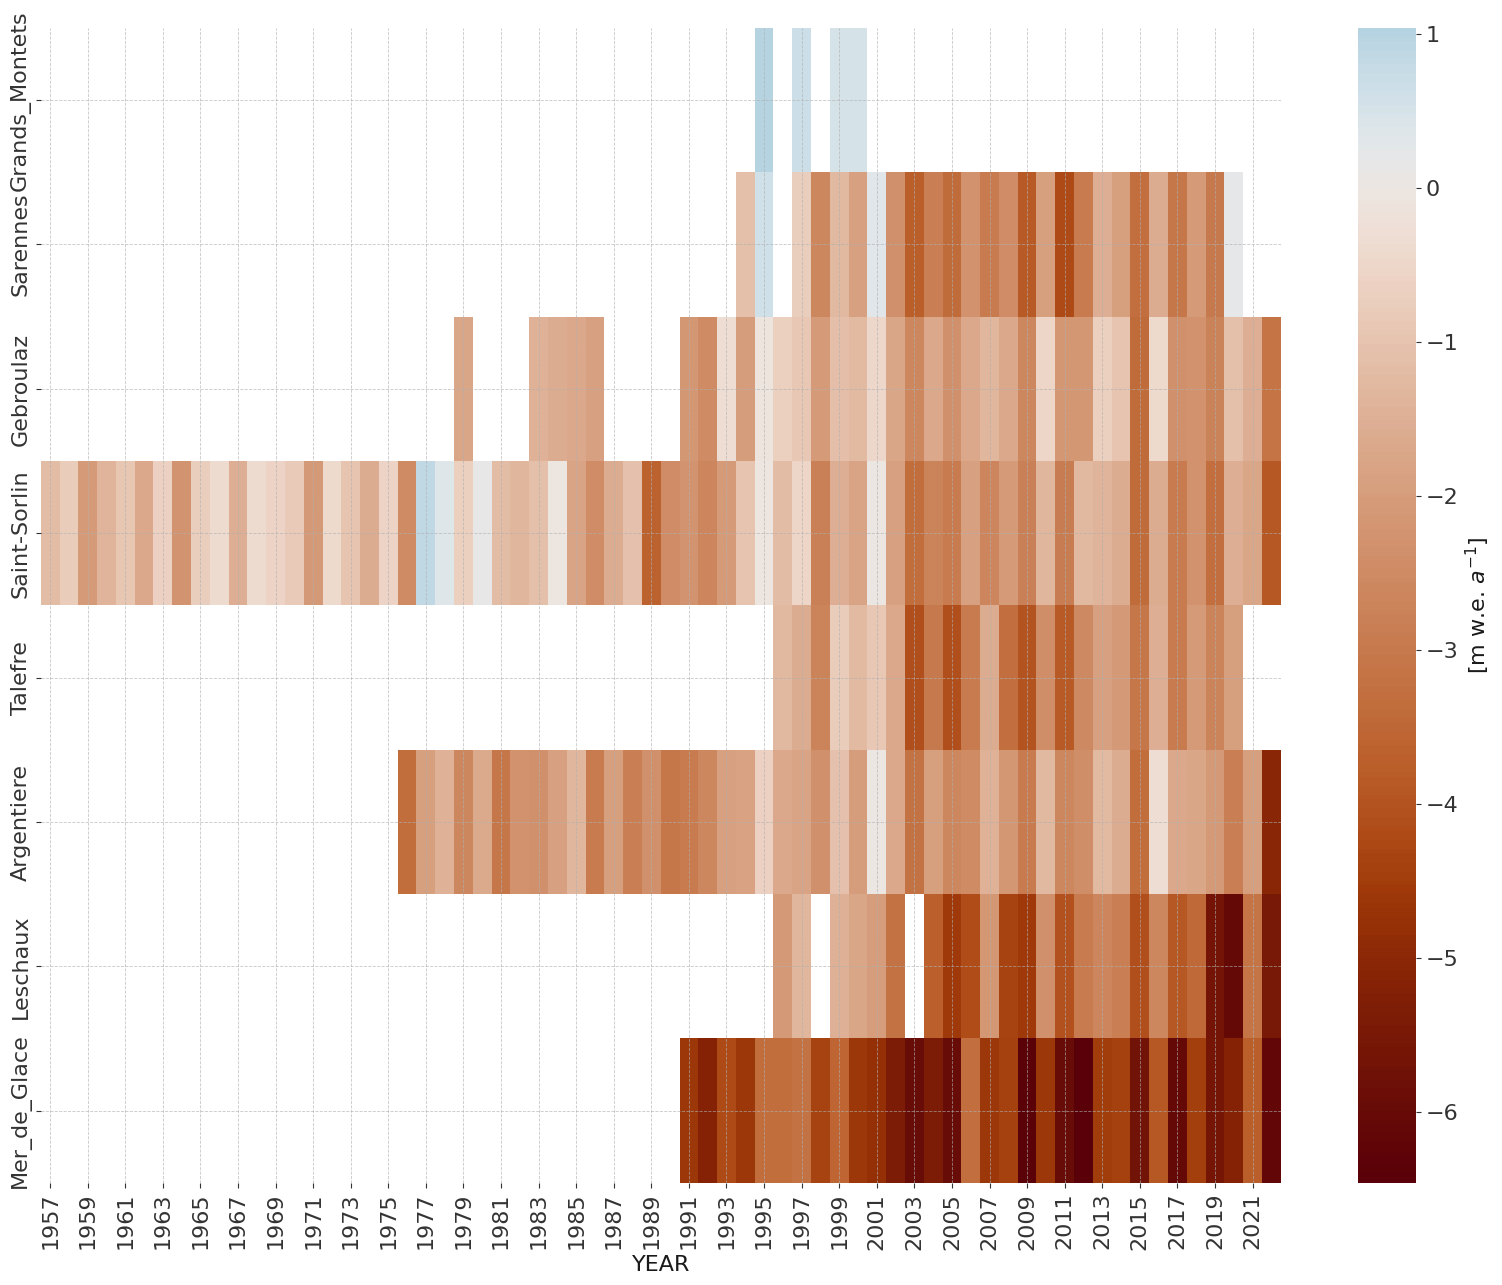

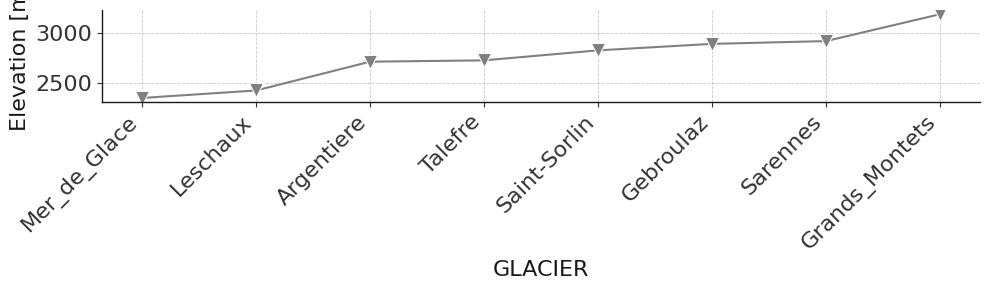

In [9]:
# Heatmap of mean mass balance per glacier:
# Get the mean mass balance per glacier

mean_mb_per_glacier = data_glacioclim.copy()
mean_mb_per_glacier['YEAR'] = mean_mb_per_glacier['TO_DATE'].astype(str).str[:4].astype(int)

mean_mb_per_glacier = mean_mb_per_glacier.groupby(
    ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] == 'annual']

matrix = mean_mb_per_glacier.pivot(
    index='GLACIER', columns='YEAR',
    values='POINT_BALANCE').sort_values(by='GLACIER')

# get elevation of glaciers:
gl_per_el = data_glacioclim.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
gl_per_el = gl_per_el.sort_values(ascending=False)

# Order matrix:
matrix = matrix.loc[gl_per_el.index]
matrix.index = pd.Categorical(matrix.index,
                              categories=matrix.index,
                              ordered=True)

# Plot heatmap:
fig = plt.figure(figsize=(20, 15))
ax = plt.subplot(1, 1, 1)
heatmap = sns.heatmap(
    data=matrix,
    center=0,
    cmap=cm.vik_r,
    cbar_kws={'label': '[m w.e. $a^{-1}$]'},
    ax=ax,
)

# Plot elevation:
fig = plt.figure(figsize=(10, 3))  # Made figure slightly taller for labels
ax = plt.subplot(1, 1, 1)
sorted_elevations = gl_per_el.sort_values(ascending=True)

sns.lineplot(sorted_elevations,
             ax=ax,
             color='gray',
             marker='v')

# Add glacier names as x-tick labels
ax.set_xticks(range(len(sorted_elevations)))
ax.set_xticklabels(sorted_elevations.index, rotation=45, ha='right')
ax.set_ylabel('Elevation [m]')
plt.tight_layout()

#### Input Dataset

In [10]:
data_glacioclim_test = data_glacioclim.copy()

print(data_glacioclim_test.shape)

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_GLACIOCLIM_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure.nc'
    #'radiation_save_path': path_pcsr + 'csv/'
}

RUN = True
dataloader_gl = process_or_load_data_glacioclim(run_flag=RUN,
                                     df=data_glacioclim_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file = 'FR_wgms_dataset_monthly_full_allnewmarijnAPI.csv')
data_monthly = dataloader_gl.data


2025-05-12 11:56:44,671 - INFO - Number of annual and seasonal samples: 10596
2025-05-12 11:56:44,672 - INFO - Running on 8 glaciers:
['Argentiere' 'Gebroulaz' 'Grands_Montets' 'Leschaux' 'Mer_de_Glace'
 'Saint-Sorlin' 'Sarennes' 'Talefre']
2025-05-12 11:56:44,690 - INFO - Number of winter, summer and annual samples: 10596
2025-05-12 11:56:44,692 - INFO - Number of annual samples: 4549


2025-05-12 11:56:44,694 - INFO - Number of winter samples: 3318
2025-05-12 11:56:44,695 - INFO - Adding climate features...


(10596, 18)


2025-05-12 11:56:49,609 - INFO - Dataset after adding climate features:
2025-05-12 11:56:49,610 - INFO - Shape: (10596, 189)
2025-05-12 11:56:49,611 - INFO - Columns: ['POINT_ID', 'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE', 'POINT_BALANCE', 'GLACIER', 'PERIOD', 'GLACIER_ZONE', 'RGIId', 'YEAR', 'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 'u10_oct', 'u10_nov', 'u10_dec', 'u10_jan', 'u10_feb', 'u10_mar', 'u10_apr', 'u10_may', 'u10_jun', 'u10_jul', 'u10_aug', 'u10_sep', 'v10_oct', 'v10_nov', 'v10_dec', 'v10_jan', 'v10_feb', 'v10_mar', 'v10_apr', 'v10_may', 'v10_jun', 'v10_jul', 'v10_aug', 'v10_sep', 't2m_oct', 't2m_nov', 't2m_dec', 't2m_jan', 't2m_feb', 't2m_mar', 't2m_apr', 't2m_may', 't2m_jun', 't2m_jul', 't2m_aug', 't2m_sep', 'fal_oct', 'fal_nov', 'fal_dec', 'fal_jan', 'fal_feb', 'fal_mar', 'fal_apr', 'fal_may', 'fal_jun', 'fal_jul', 'fal_aug', 'fal_sep', 'snowc_oct', 'snowc_nov', 'snowc_dec', 'snowc_jan', 'snowc_feb', 'sno

In [11]:
display(data_monthly.head(2))
display('------------------')
display(data_glacioclim_test['GLACIER'].unique())
display(data_monthly['GLACIER'].unique())
display('----------LANGUE GLACIER ZONE--------')
display(data_monthly[data_monthly['GLACIER_ZONE'] == 'Langue'].head(2))

display('----------STSO------------')
display(data_monthly[data_monthly['POINT_ID'] == 'stso_annual_smb_abl_2007_setup2006_6'].columns)

display(data_monthly[data_monthly['ELEVATION_DIFFERENCE'] < 0])

print(data_monthly.columns)

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2006   7.024819  45.944607          -0.67       2524.444781   
1  2006   7.024819  45.944607          -0.67       2524.444781   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            509.075219          3033.52  RGI60-11.03638   
1            509.075219          3033.52  RGI60-11.03638   

                                            POINT_ID  ID  ...  millan_v  \
0  Argentiere_Tour_Noir_annual_smb_abl_2006_setup...   0  ...  5.479116   
1  Argentiere_Tour_Noir_annual_smb_abl_2006_setup...   0  ...  5.479116   

        t2m        tp       slhf      sshf        ssrd       fal        str  \
0  1.863434  0.002194 -1039166.0 -437704.0  10756431.0  0.497862 -3961346.0   
1 -5.253510  0.001675  -277848.0 -212654.0   7246084.0  0.564720 -3621156.0   

        u10       v10  
0 -0.321241  0.331826  
1 -0.175529  0.153369  

[2 rows x 29 columns]

'------------------'

array(['Argentiere', 'Gebroulaz', 'Grands_Montets', 'Leschaux',
       'Mer_de_Glace', 'Saint-Sorlin', 'Sarennes', 'Talefre'],
      dtype=object)

array(['Argentiere', 'Gebroulaz', 'Grands_Montets', 'Leschaux',
       'Mer_de_Glace', 'Saint-Sorlin', 'Sarennes', 'Talefre'],
      dtype=object)

'----------LANGUE GLACIER ZONE--------'

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
48239  1996   6.942335   45.90707          -5.49       2336.982377   
48240  1996   6.942335   45.90707          -5.49       2336.982377   

       ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
48239           -262.052377          2074.93  RGI60-11.03643   
48240           -262.052377          2074.93  RGI60-11.03643   

                                         POINT_ID    ID  ...   millan_v  \
48239  mdg_langue_annual_smb_abl_1996_setup1995_1  5593  ...  27.030954   
48240  mdg_langue_annual_smb_abl_1996_setup1995_1  5593  ...  27.030954   

            t2m        tp      slhf      sshf       ssrd       fal        str  \
48239 -6.309418  0.003661 -312744.0 -337880.0  7617248.0  0.561271 -3394290.0   
48240 -9.916107  0.005198  -12634.0  -37798.0  5046172.0  0.687234 -1889316.0   

            u10       v10  
48239 -0.479674  0.192175  
48240 -0.596169  0.465025  

[2 rows x 29 columns]

'----------STSO------------'

Index(['YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE', 'ALTITUDE_CLIMATE',
       'ELEVATION_DIFFERENCE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
       'N_MONTHS', 'MONTHS', 'PERIOD', 'GLACIER', 'GLACIER_ZONE', 'aspect',
       'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m',
       'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'],
      dtype='object')

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
44681  1996   6.981268  45.887749          -1.91       2524.444781   
44682  1996   6.981268  45.887749          -1.91       2524.444781   
44683  1996   6.981268  45.887749          -1.91       2524.444781   
44684  1996   6.981268  45.887749          -1.91       2524.444781   
44685  1996   6.981268  45.887749          -1.91       2524.444781   
...     ...        ...        ...            ...               ...   
58161  2022   6.938533  45.895688           0.74       2336.982377   
58162  2022   6.938533  45.895688           0.74       2336.982377   
58163  2022   6.938533  45.895688           0.74       2336.982377   
58164  2022   6.938533  45.895688           0.74       2336.982377   
58165  2022   6.938533  45.895688           0.74       2336.982377   

       ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
44681            -24.444781          2500.00  RGI60-11.03642   
44682            -24.444781          2500.00  RGI60-11.03642   
44683            -24.444781          2500.00  RGI60-11.03642   
44684            -24.444781          2500.00  RGI60-11.03642   
44685            -24.444781          2500.00  RGI60-11.03642   
...                     ...              ...             ...   
58161           -233.032377          2103.95  RGI60-11.03643   
58162           -233.032377          2103.95  RGI60-11.03643   
58163           -233.032377          2103.95  RGI60-11.03643   
58164           -233.032377          2103.95  RGI60-11.03643   
58165           -233.032377          2103.95  RGI60-11.03643   

                                           POINT_ID    ID  ...   millan_v  \
44681  mdg_Leschaux_annual_smb_abl_1996_setup1995_3  5162  ...  59.547447   
44682  mdg_Leschaux_annual_smb_abl_1996_setup1995_3  5162  ...  59.547447   
44683  mdg_Leschaux_annual_smb_abl_1996_setup1995_3  5162  ...  59.547447   
44684  mdg_Leschaux_annual_smb_abl_1996_setup1995_3  5162  ...  59.547447   
44685  mdg_Leschaux_annual_smb_abl_1996_setup1995_3  5162  ...  59.547447   
...                                             ...   ...  ...        ...   
58161     mdg_Tacul_winter_smb_abl_2022_setup2021_4  6781  ...  37.058777   
58162     mdg_Tacul_winter_smb_abl_2022_setup2021_4  6781  ...  37.058777   
58163     mdg_Tacul_winter_smb_abl_2022_setup2021_4  6781  ...  37.058777   
58164     mdg_Tacul_winter_smb_abl_2022_setup2021_4  6781  ...  37.058777   
58165     mdg_Tacul_winter_smb_abl_2022_setup2021_4  6781  ...  37.058777   

             t2m        tp       slhf       sshf        ssrd       fal  \
44681   1.192780  0.002591 -2241716.0 -1451030.0  15390639.0  0.466632   
44682   3.017487  0.000670 -1468208.0  -682224.0  11732658.0  0.428953   
44683  -7.112152  0.003412  -111616.0   -30672.0   7700036.0  0.725517   
44684 -10.724701  0.004781    20902.0   125236.0   5130764.0  0.810723   
44685  -9.884857  0.002065    58140.0   229506.0   7016012.0  0.818057   
...          ...       ...        ...        ...         ...       ...   
58161  -9.387299  0.008475    33666.0   121156.0   5230264.0  0.698602   
58162 -10.077240  0.002324    24102.0   117108.0   7488184.0  0.672153   
58163  -7.700043  0.005706   -43146.0  -505290.0  10423162.0  0.714930   
58164  -5.169525  0.000854  -437710.0 -1139358.0  17865204.0  0.635412   
58165  -2.392914  0.005103  -580502.0 -2133090.0  20993824.0  0.656071   

             str       u10       v10  
44681 -4423727.0  0.033295 -0.128937  
44682 -4332690.0 -0.254977  0.280252  
44683 -2830412.0 -0.400084  0.220495  
44684 -1370024.0 -0.516091  0.513365  
44685 -2126324.0 -0.839980  0.671829  
...          ...       ...       ...  
58161 -2025781.0 -0.599898  0.439262  
58162 -3179020.0 -0.690116  0.349599  
58163 -2902630.0 -0.190032  0.281082  
58164 -5025112.0 -0.599691  0.441924  
58165 -4291728.0 -0.089779  0.142343  

[12514 rows x 29 columns]

Index(['YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE', 'ALTITUDE_CLIMATE',
       'ELEVATION_DIFFERENCE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
       'N_MONTHS', 'MONTHS', 'PERIOD', 'GLACIER', 'GLACIER_ZONE', 'aspect',
       'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m',
       'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'],
      dtype='object')


#### Nr. of measurements per year

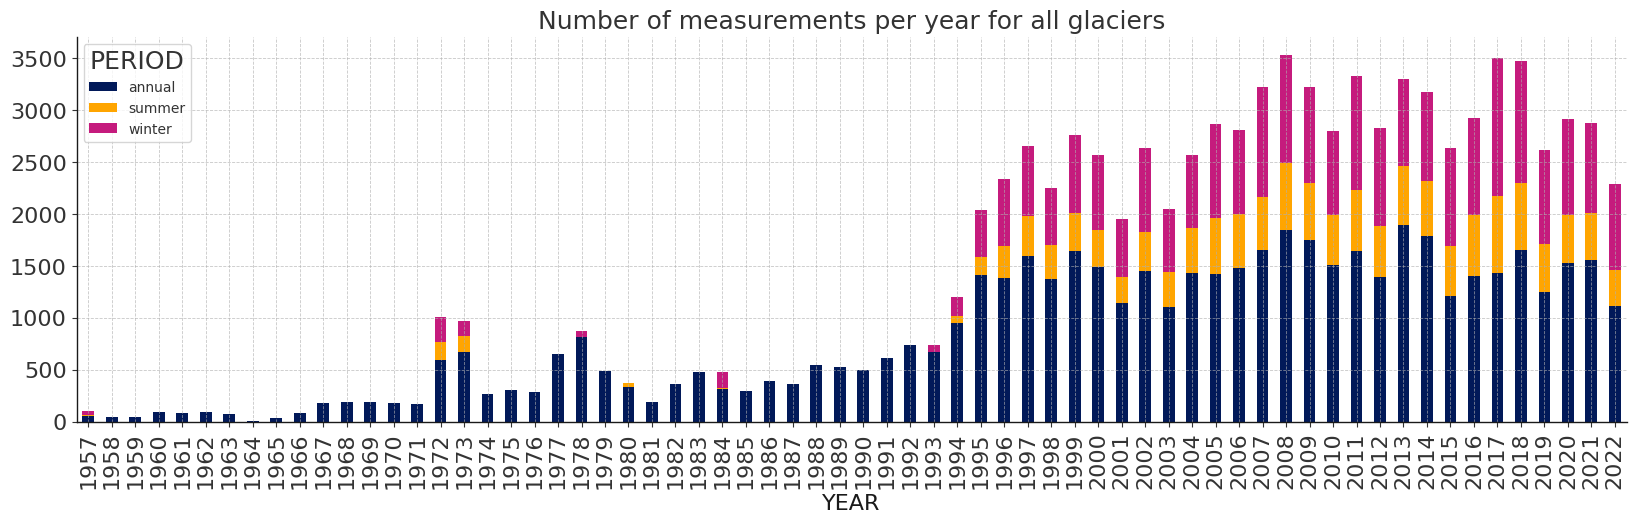

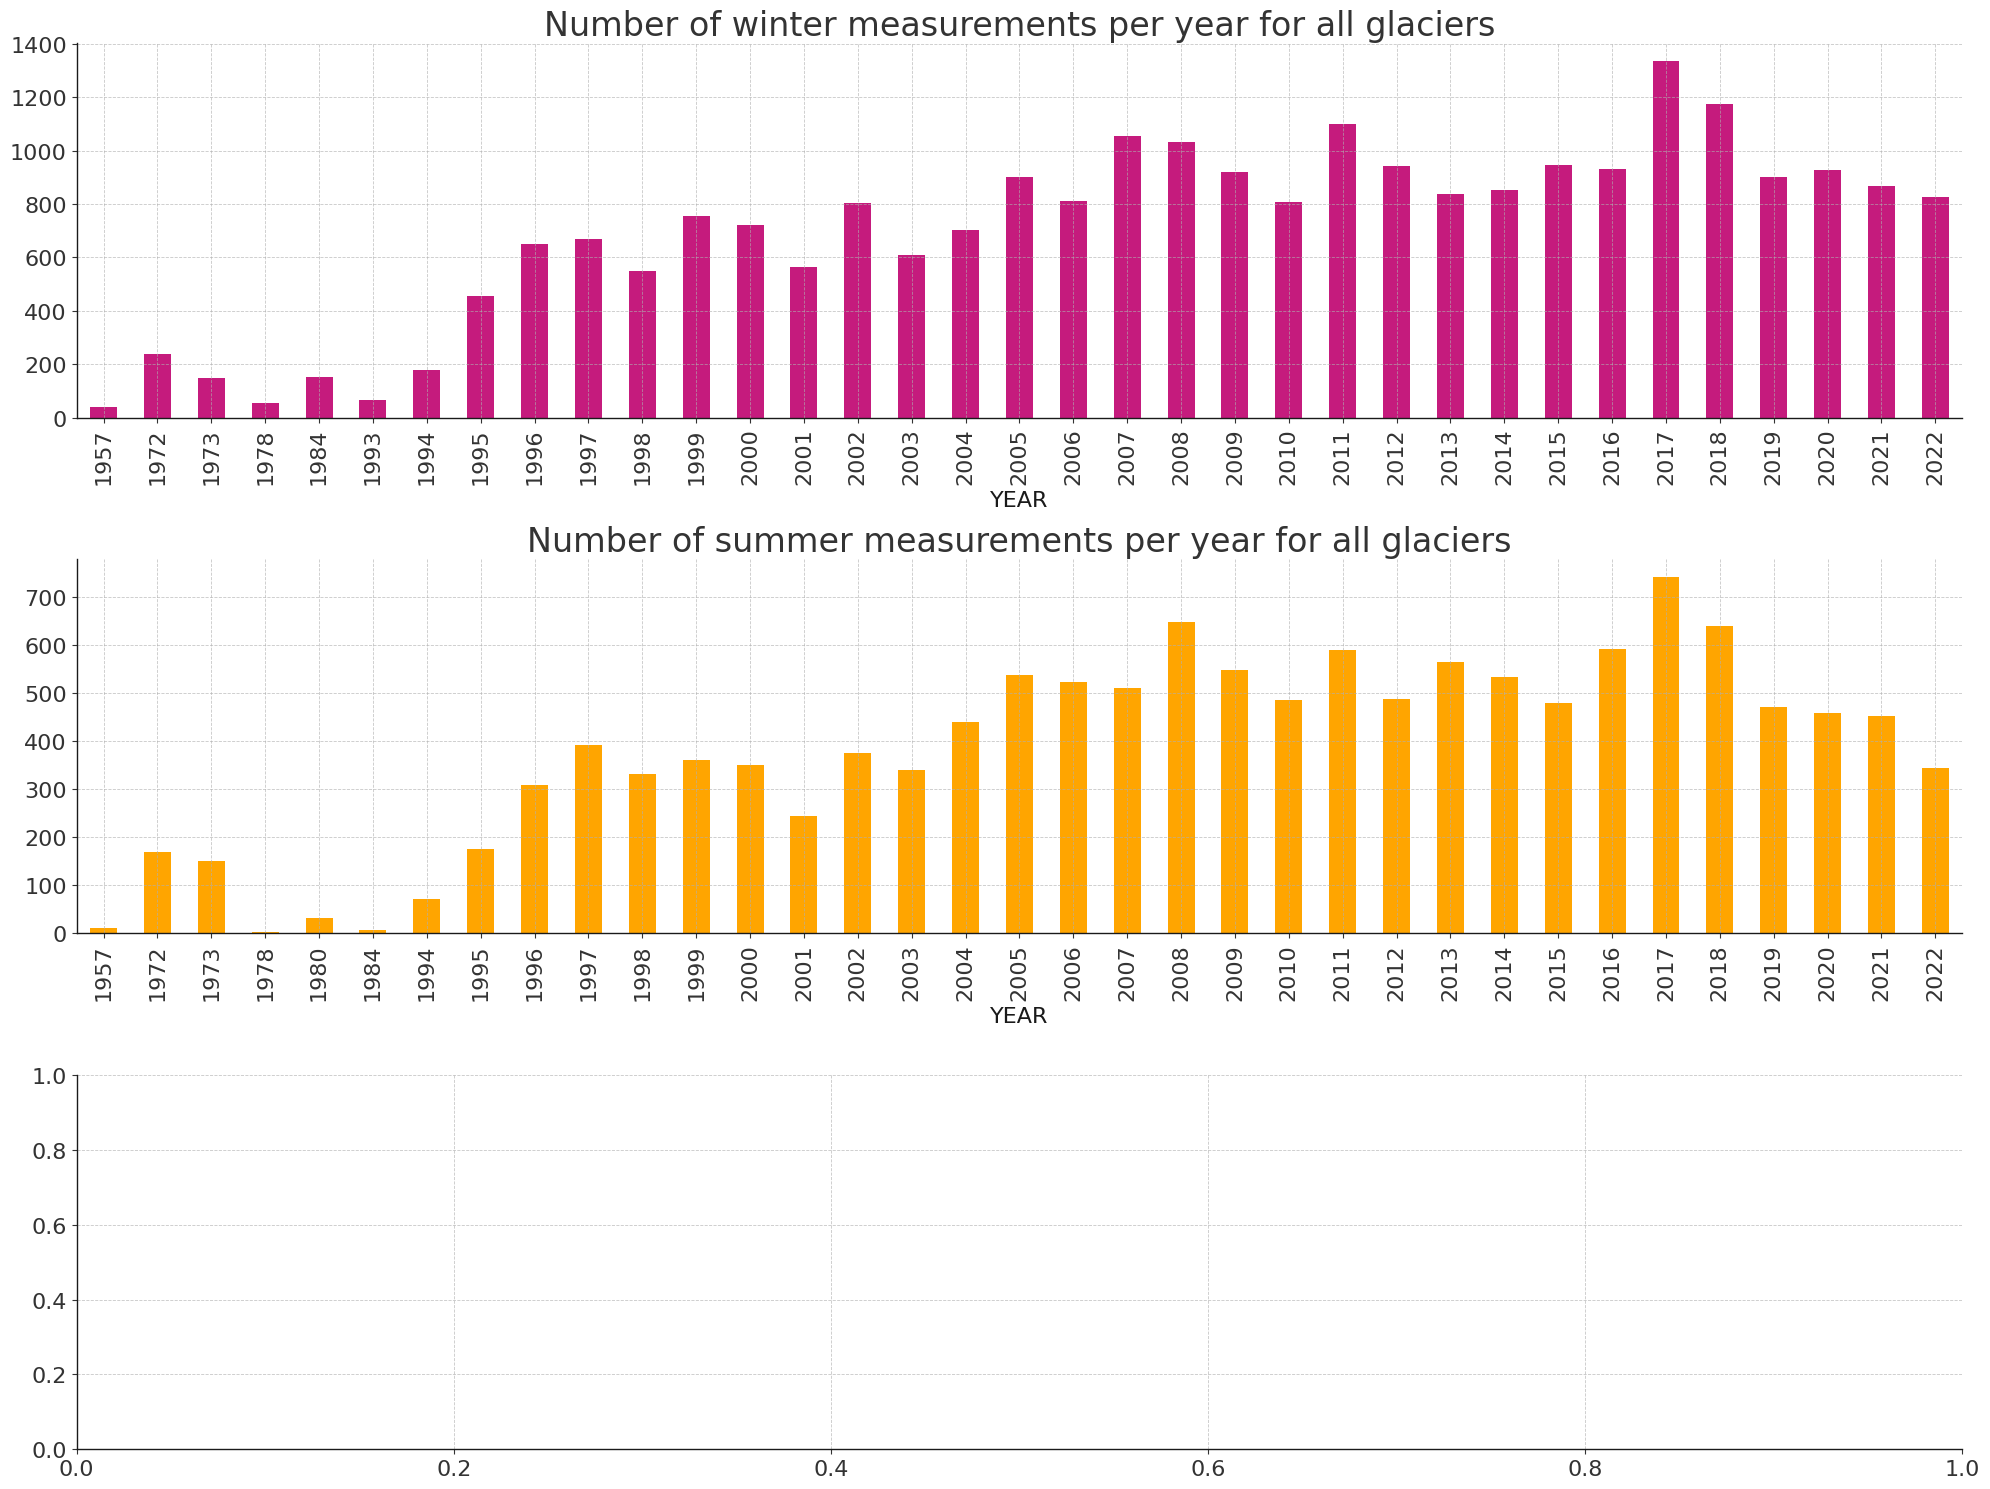

In [12]:
# Number of measurements per year:
data_monthly.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_orange, color_pink])
plt.title('Number of measurements per year for all glaciers')

# Plot winter, summer and annual separately:
fig, axs = plt.subplots(3, 1, figsize=(20, 15), sharey=False)

# Winter plot
data_monthly[data_monthly.PERIOD == 'winter'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(
        kind='bar',
        ax=axs[0],
        color=[color_pink],
        legend=False)
axs[0].set_title('Number of winter measurements per year for all glaciers',
                 fontsize=24)

# Summer plot
data_monthly[data_monthly.PERIOD == 'summer'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(
        kind='bar',
        ax=axs[1],
        color=[color_orange],
        legend=False)
axs[1].set_title('Number of summer measurements per year for all glaciers',
                 fontsize=24)

"""
# Annual plot 
data_monthly[data_monthly.PERIOD == 'annual'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(
        kind='bar',
        ax=axs[2], 
        color=[color_dark_blue],
        legend=False)
axs[2].set_title('Number of annual measurements per year for all glaciers',
                 fontsize=24)
"""

plt.tight_layout()

### Correction for elevation difference:

In [52]:
"""
### NO GLOGEM DATA

# Load and preprocess GloGEM factors
path_glogem_factors = os.path.join(path_glogem, 'reference_run_GloGEM2024.csv')
glogem_factors = pd.read_csv(path_glogem_factors)
glogem_factors.rename(columns={'ID': 'RGIId'}, inplace=True)
glogem_factors['RGIId'] = glogem_factors['RGIId'].apply(
    lambda x: format_rgi_code(x))

c_prec_dic, t_off_dic = {}, {}
for gl in data_monthly.GLACIER.unique():
    rgi_gl = data_monthly[data_monthly.GLACIER == gl].RGIId.unique()[0]
    factor_gl = glogem_factors[glogem_factors.RGIId == rgi_gl]
    c_prec_dic[gl] = factor_gl['Cprec'].values[0]
    t_off_dic[gl] = factor_gl['T_off'].values[0]

# Mean of dic values
mean_c_prec = np.max(list(c_prec_dic.values()))
mean_t_off = np.max(list(t_off_dic.values()))
print(f"Mean Cprec: {mean_c_prec}, Mean T_off: {mean_t_off}")

# Correct t2m and tp for elevation
dataloader_gl.correct_for_elevation()

# Plot the distribution of corrected and uncorrected precipitation and temperature
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Precipitation
sns.histplot(data_monthly['tp'],
             bins=50,
             kde=True,
             label='tp',
             alpha=0.5,
             ax=axes[0])
sns.histplot(data_monthly['tp_corr'],
             bins=50,
             kde=True,
             label='tp_corr',
             alpha=0.5,
             ax=axes[0])
axes[0].set_title('Distribution of Precipitation')
axes[0].set_xlabel('Precipitation (tp / tp_corr)')
axes[0].legend()

# Temperature
sns.histplot(data_monthly['t2m'],
             bins=50,
             kde=True,
             label='t2m',
             alpha=0.5,
             ax=axes[1])
sns.histplot(data_monthly['t2m_corr'],
             bins=50,
             kde=True,
             label='t2m_corr',
             alpha=0.5,
             ax=axes[1])
axes[1].set_title('Distribution of Temperature')
axes[1].set_xlabel('Temperature (t2m / t2m_corr)')
axes[1].legend()

plt.tight_layout()
plt.show()
"""

'\n### NO GLOGEM DATA\n\n# Load and preprocess GloGEM factors\npath_glogem_factors = os.path.join(path_glogem, \'reference_run_GloGEM2024.csv\')\nglogem_factors = pd.read_csv(path_glogem_factors)\nglogem_factors.rename(columns={\'ID\': \'RGIId\'}, inplace=True)\nglogem_factors[\'RGIId\'] = glogem_factors[\'RGIId\'].apply(\n    lambda x: format_rgi_code(x))\n\nc_prec_dic, t_off_dic = {}, {}\nfor gl in data_monthly.GLACIER.unique():\n    rgi_gl = data_monthly[data_monthly.GLACIER == gl].RGIId.unique()[0]\n    factor_gl = glogem_factors[glogem_factors.RGIId == rgi_gl]\n    c_prec_dic[gl] = factor_gl[\'Cprec\'].values[0]\n    t_off_dic[gl] = factor_gl[\'T_off\'].values[0]\n\n# Mean of dic values\nmean_c_prec = np.max(list(c_prec_dic.values()))\nmean_t_off = np.max(list(t_off_dic.values()))\nprint(f"Mean Cprec: {mean_c_prec}, Mean T_off: {mean_t_off}")\n\n# Correct t2m and tp for elevation\ndataloader_gl.correct_for_elevation()\n\n# Plot the distribution of corrected and uncorrected precipi

### Feature correlation:

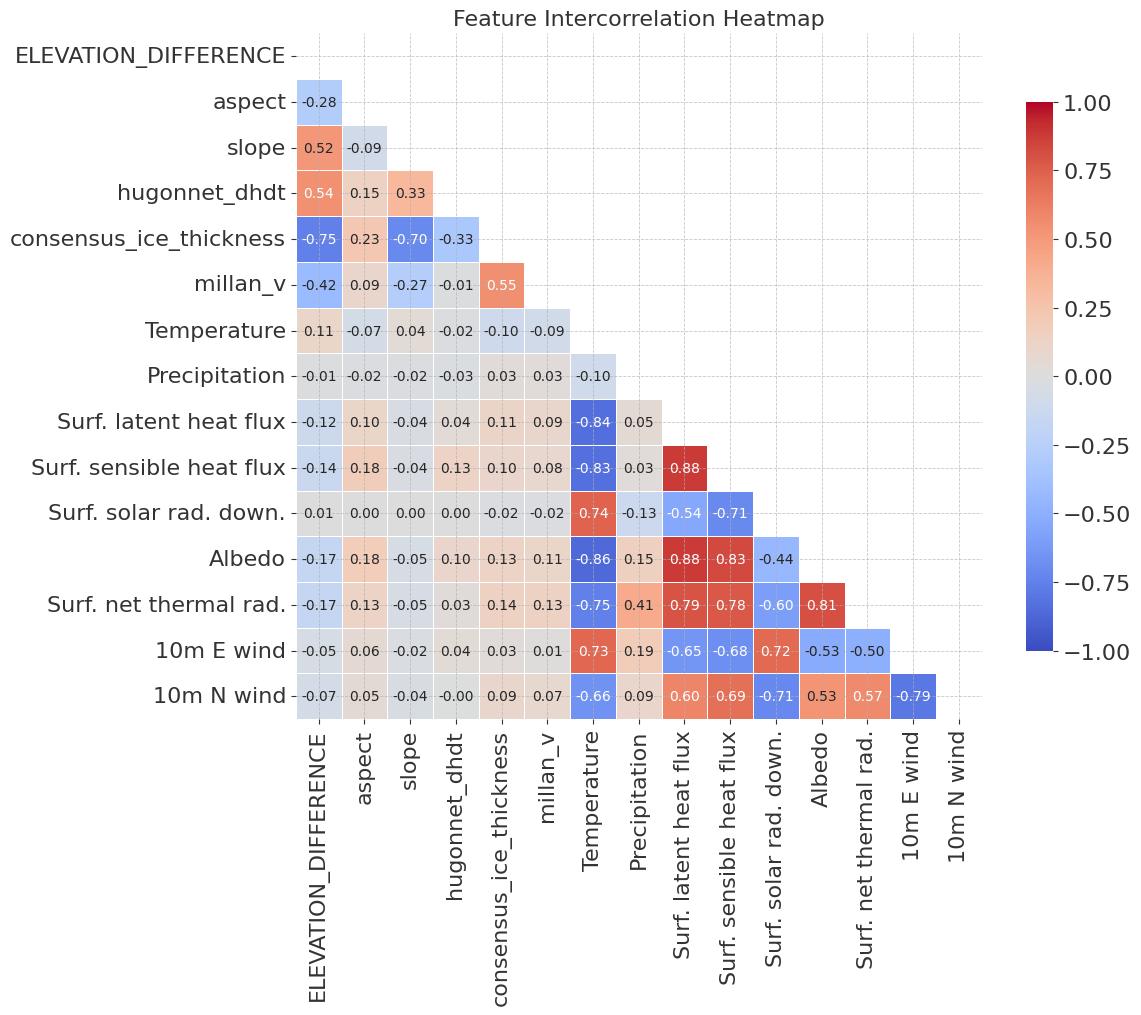

In [13]:
# Prepare data for correlation analysis
df = dataloader_gl.data.copy().dropna()

# Define the columns to keep
columns_to_keep = [
    col for col in df.columns if col not in [
        'GLACIER', 'PERIOD', 'YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE',
        'ALTITUDE_CLIMATE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
        'N_MONTHS', 'MONTHS', 'GLACIER_ZONE'
    ]
]
df = df[columns_to_keep]

# Rename columns based on long names (if applicable)
df.rename(columns=vois_climate_long_name, inplace=True)

# Compute correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    vmax=1,
    vmin=-1,
    center=0,
    annot=True,  # Add correlation values
    fmt=".2f",
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": 0.8})

# Enhance readability
plt.title("Feature Intercorrelation Heatmap", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

### Sanity checks:

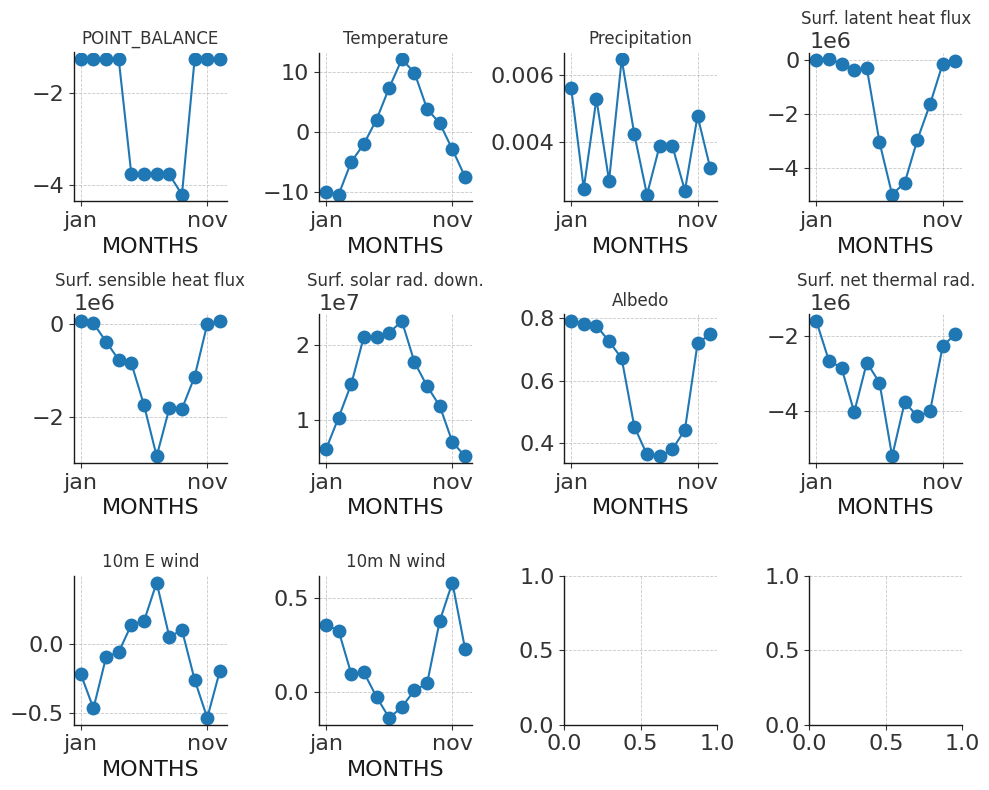

In [14]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate
df = df[(df.GLACIER == 'Argentiere') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

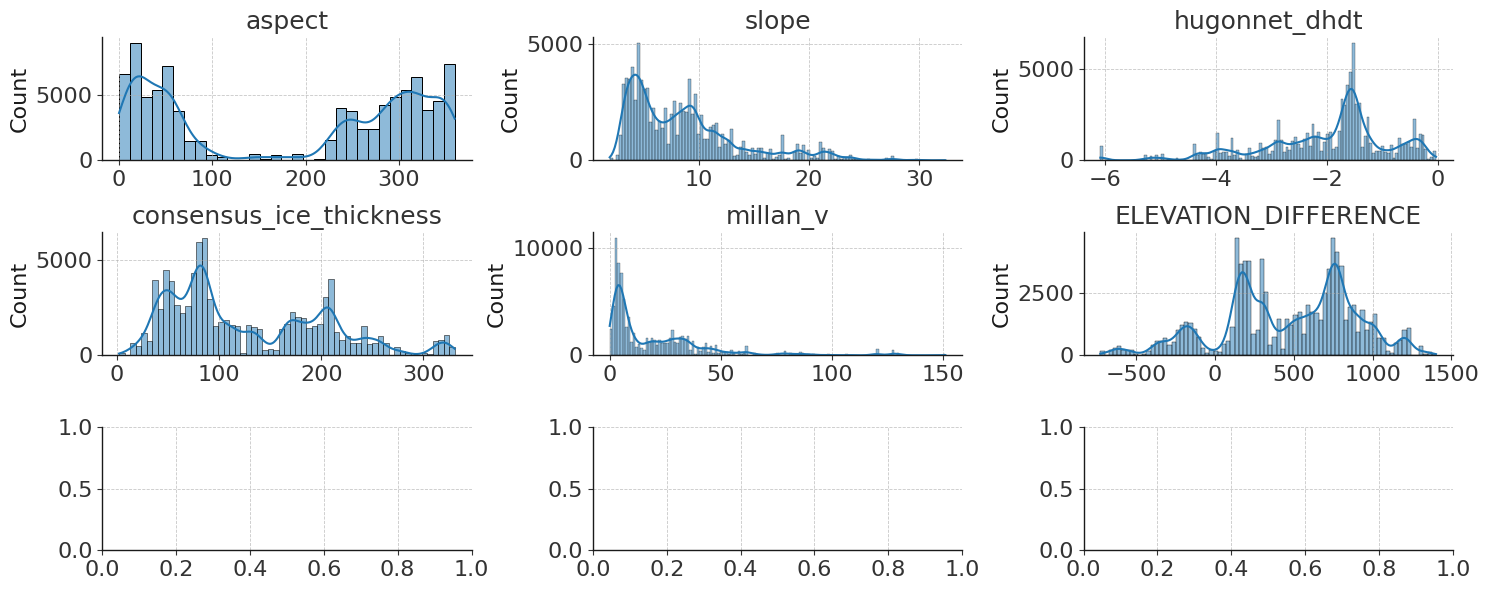

In [15]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

## Blocking on glaciers:
### Spatial Cross-Validation

In [19]:
test_glaciers = ['Gebroulaz']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of test data:', len(data_test))

data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))

if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

# Number of annual versus winter measurements:
print('Train:')
print('Number of winter, summer and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_train[data_train.PERIOD == 'summer']))

# Same for test
data_test_annual = data_test[data_test.PERIOD == 'annual']
data_test_winter = data_test[data_test.PERIOD == 'winter']
data_test_summer = data_test[data_test.PERIOD == 'summer']

print('Test:')
print('Number of winter, summer and annual samples:', len(data_test))
print('Number of annual samples:', len(data_test_annual))
print('Number of winter samples:', len(data_test_winter))
print('Number of summer samples:', len(data_test_summer))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))
print('Number of summer rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'summer']))

Size of test data: 15006
Size of train data: 77412
Percentage of test size: 19.38%
Train:
Number of winter, summer and annual samples: 77412
Number of annual samples: 46280
Number of winter samples: 20254
Number of summer samples: 10878
Test:
Number of winter, summer and annual samples: 15006
Number of annual samples: 8222
Number of winter samples: 4282
Number of summer samples: 2502
Total:
Number of monthly rows: 92418
Number of annual rows: 54502
Number of winter rows: 24536
Number of summer rows: 13380


#### Heatmap annual:

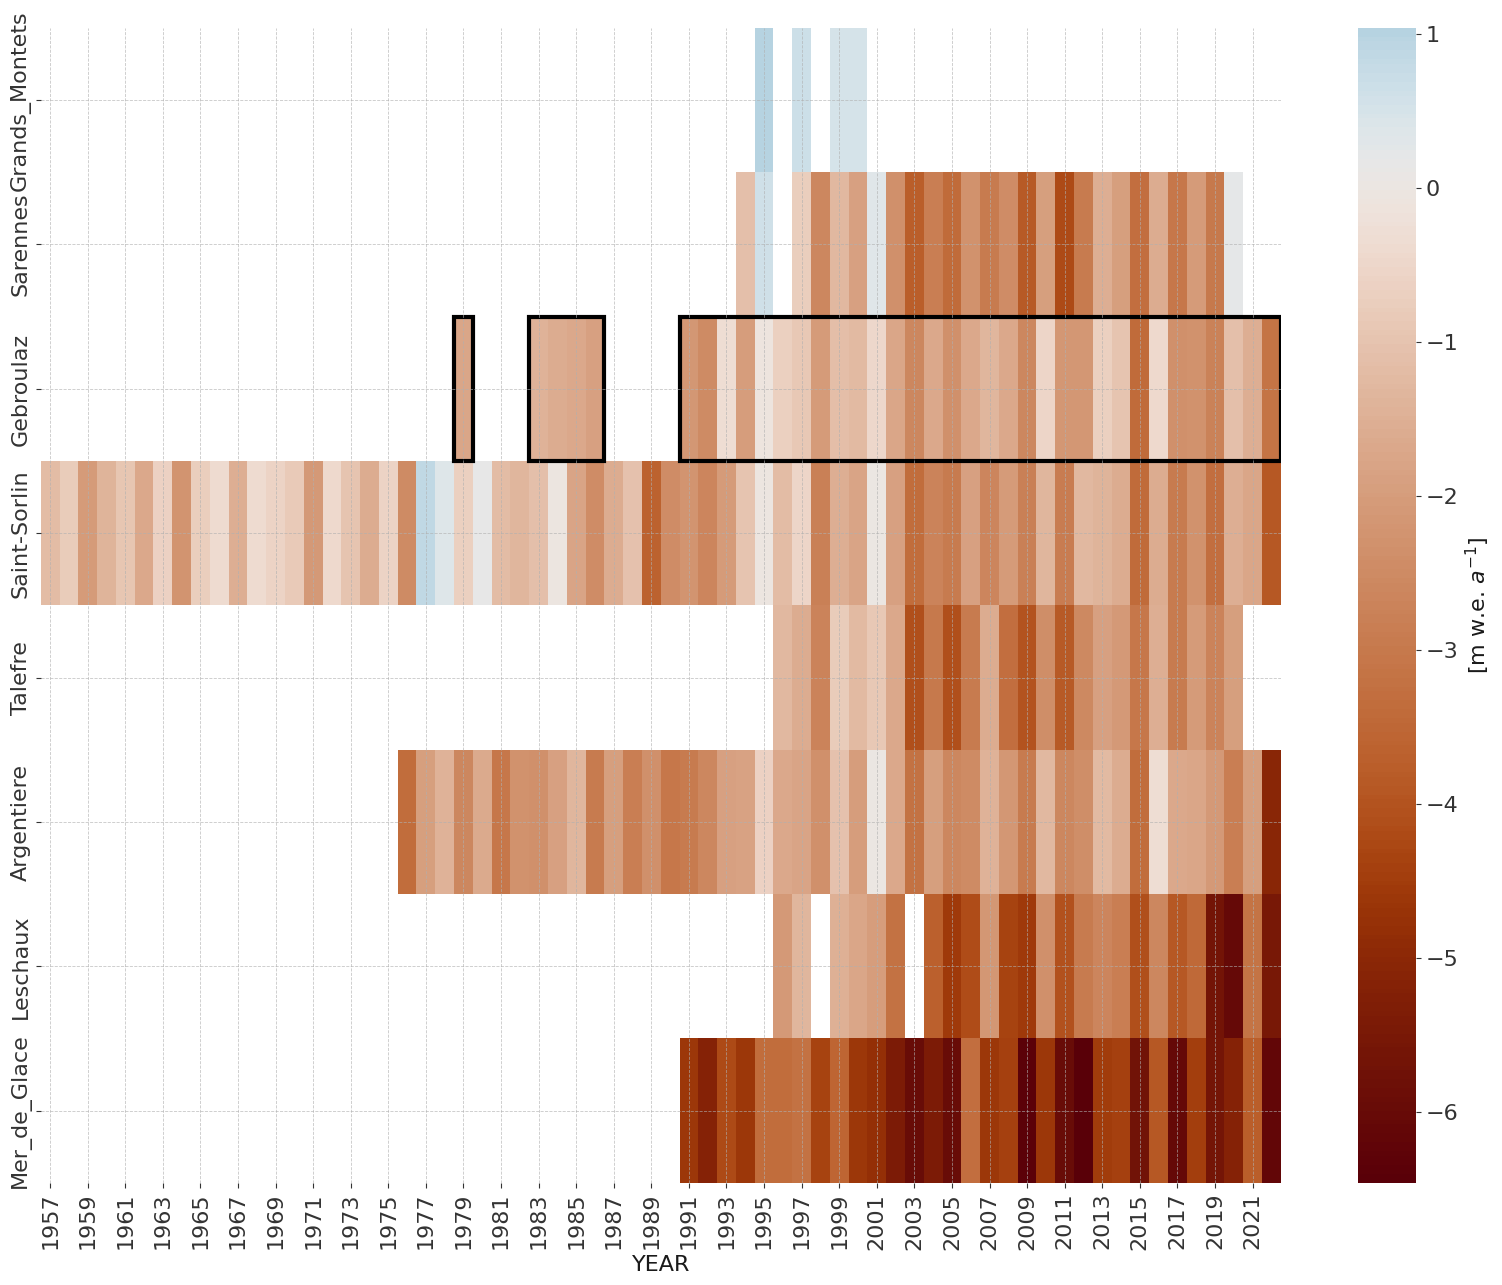

In [20]:
plotHeatmap(test_glaciers, data_glacioclim, period='annual')

#### Heatmap winter:

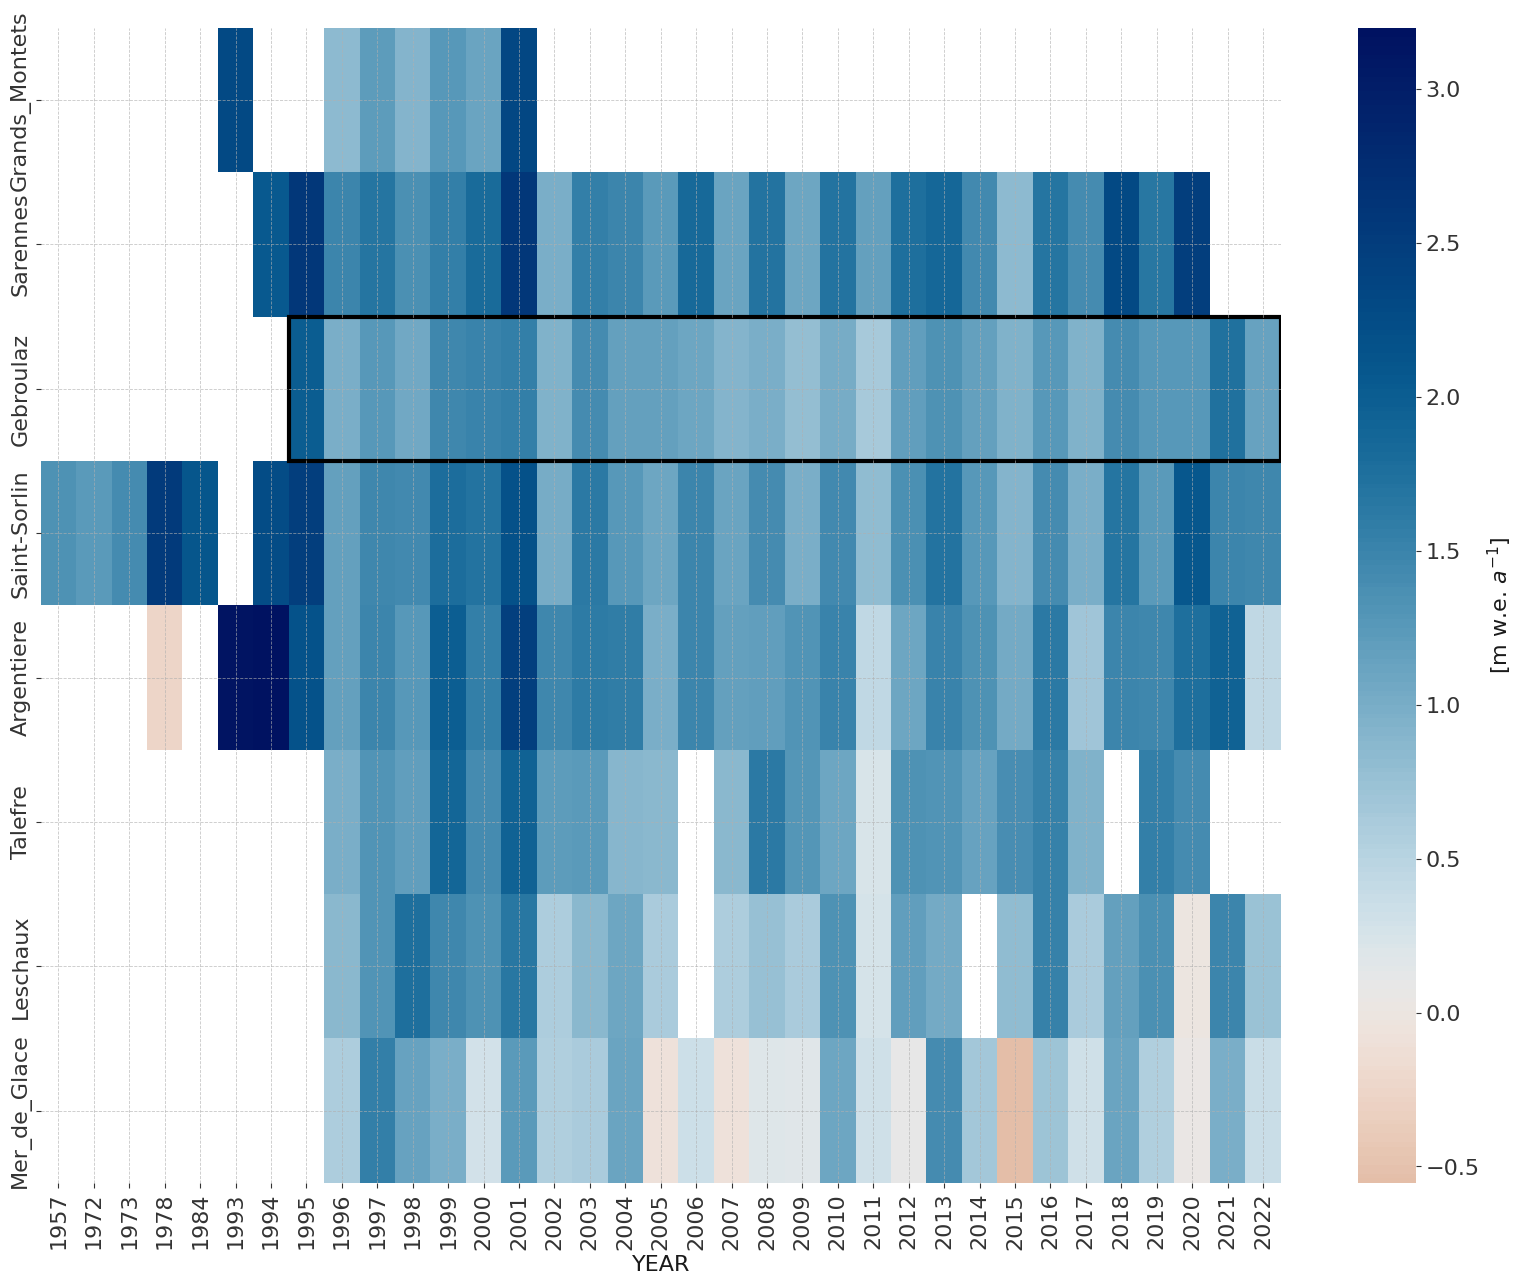

In [21]:
plotHeatmap(test_glaciers, data_glacioclim, period='winter')

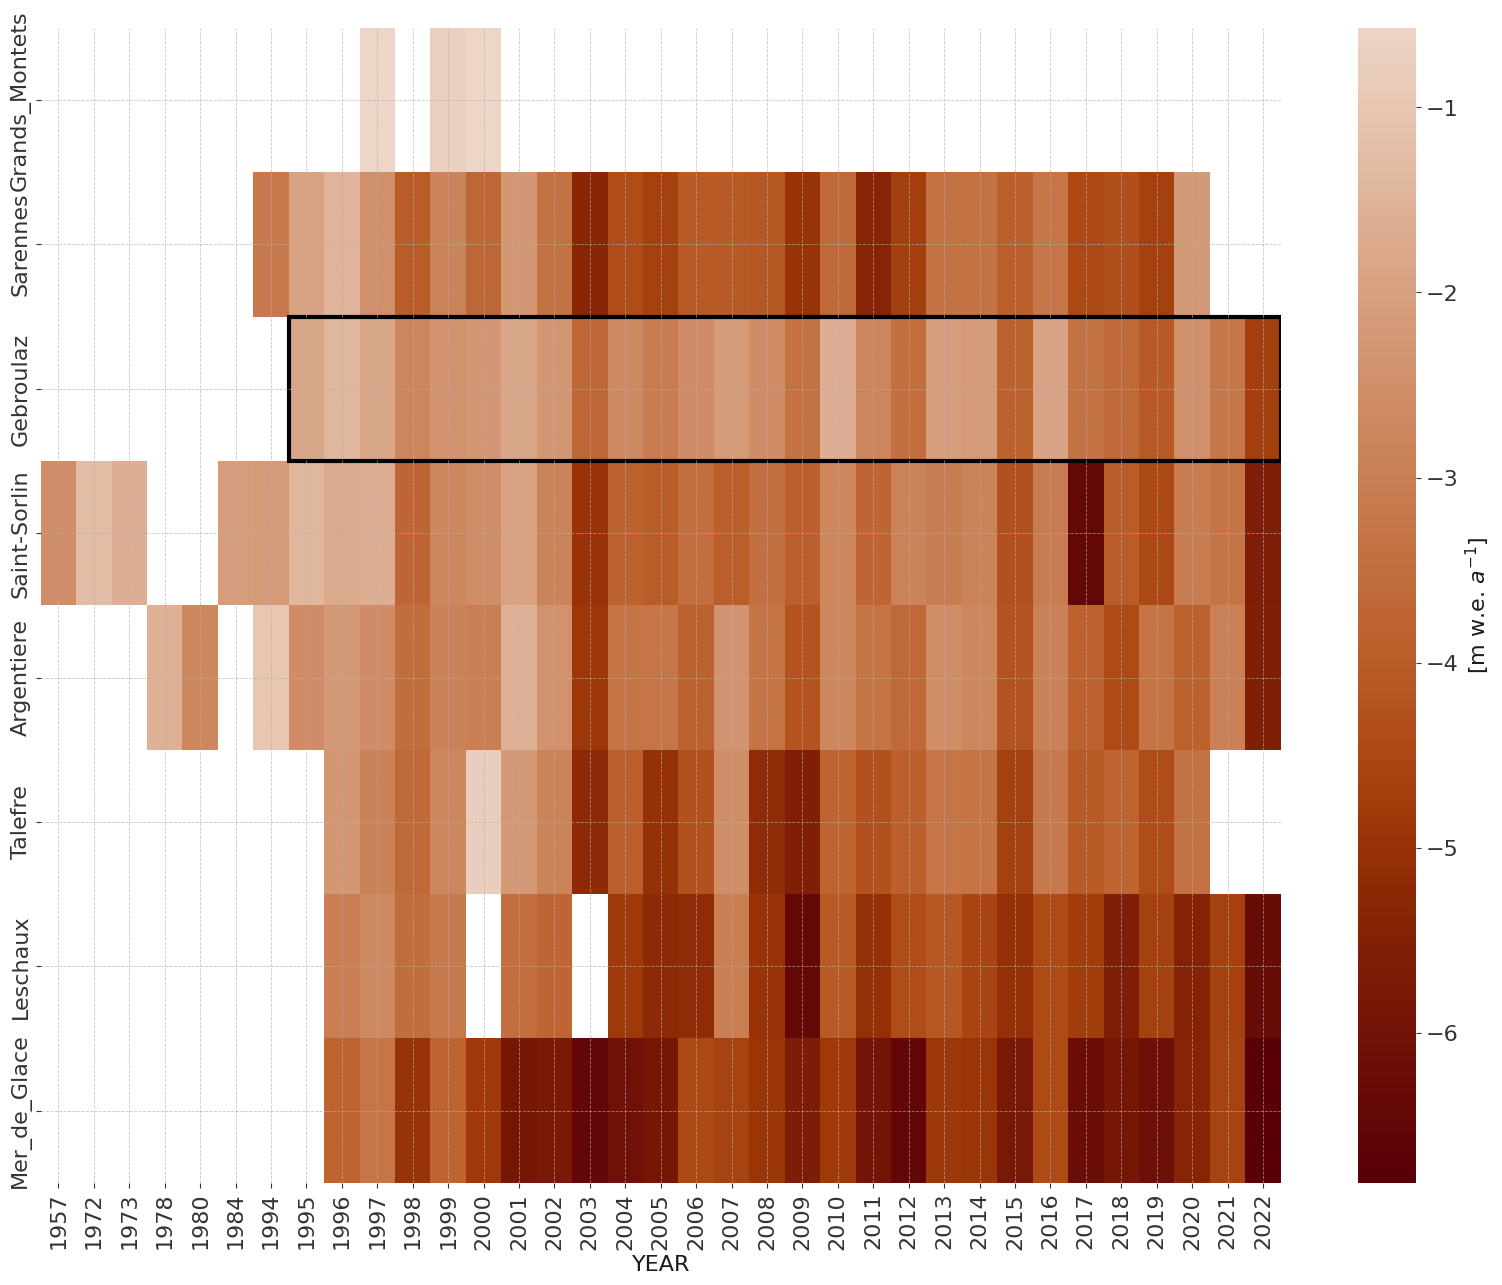

In [22]:
plotHeatmap(test_glaciers, data_glacioclim, period='summer')

#### Spatial Glacier based CV splits:

Test glaciers: (1) ['Gebroulaz']
Percentage of test size: 19.38%
Size of test set: 15006
Train glaciers: (7) ['Argentiere' 'Grands_Montets' 'Leschaux' 'Mer_de_Glace' 'Saint-Sorlin'
 'Sarennes' 'Talefre']
Size of train set: 77412


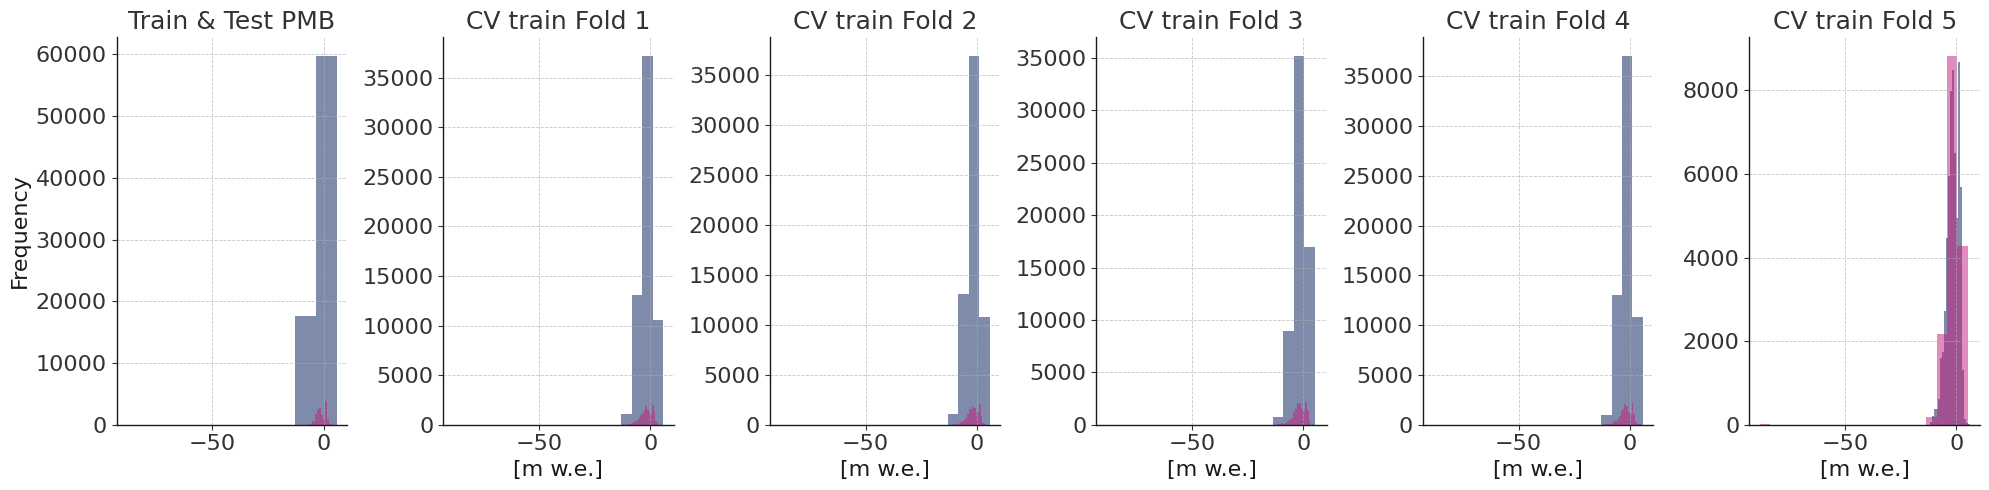

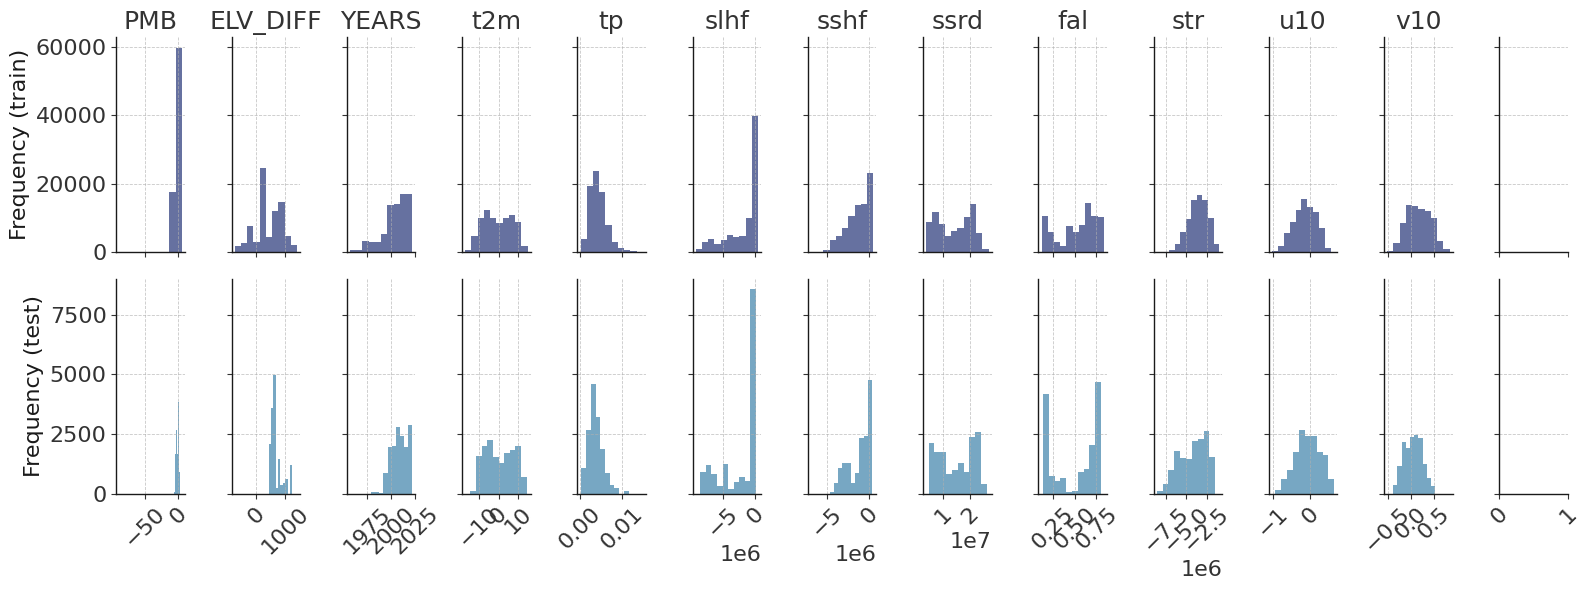

In [23]:
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))

visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

#### Stake based CV Splits

In [ ]:
## This is a split by POINT_ID, the problem is that POINT_ID is not synonymous with the actual stakes, but unique for every measurement.
## So in the end there will be the same stake with different POINT_IDs for different years, this means that the same stake might be in the train and test set.
## This is more out of curiosity though anyways, we are not really going for single stake predictions.


splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='POINT_ID',
                                            test_splits=None,
                                            random_state=cfg.seed,
                                            test_size=0.2)

print('Test stakes: ({}) {}'.format(
    len(test_set['splits_vals']), 
    test_set['splits_vals'][:5] if len(test_set['splits_vals']) > 5 else test_set['splits_vals'])
)
if len(test_set['splits_vals']) > 5:
    print('... and {} more stakes'.format(len(test_set['splits_vals']) - 5))

test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Size of train set:', len(train_set['df_X']))

test_stakes_by_glacier = test_set['df_X'].groupby('GLACIER')['POINT_ID'].nunique()
print('\nTest stakes distribution by glacier:')
for glacier, count in test_stakes_by_glacier.items():
    print(f"  {glacier}: {count} stakes")


visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)


#### Temporal CV Split

In [ ]:
# Remove last 5 years of data and use as test set

test_years_count = 5

all_years = sorted(dataloader_gl.data['YEAR'].unique())

# Use the most recent years as test data
train_years = all_years[:-test_years_count]
test_years = all_years[-test_years_count:]

print(f"Training on years: {train_years}")
print(f"Testing on years: {test_years}")

splits, test_set, train_set = get_CV_splits(
                                dataloader_gl,
                                test_split_on='YEAR',
                                test_splits=test_years,
                                random_state=cfg.seed)

print('Test years: {}'.format(test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train years: {}'.format(train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))


test_samples_by_year = test_set['df_X'].groupby(['YEAR', 'PERIOD']).size()
print('\nTest samples by year and period:')
print(test_samples_by_year)

visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)
    


#### Split train CH and test FR

In [15]:
display(data_monthly.head(2))

data_monthly_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/WGMS_all/CH_wgms_dataset_monthly_full_newAPI_nopcsr.csv')
#remove pcsr column if present
#data_monthly_CH = data_monthly_CH.drop(columns=['pcsr'])
column_mapping = {'aspect_sgi': 'aspect', 'slope_sgi': 'slope'}
data_monthly_CH = data_monthly_CH.rename(columns=column_mapping)
data_monthly_CH['GLACIER_ZONE'] = 'Placeholder'

display(data_monthly_CH.head(2))

data_monthly = data_monthly[data_monthly['PERIOD'] != 'summer']

display(data_monthly['PERIOD'].unique())

display(type(data_monthly))

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2006   7.024819  45.944607          -0.67       1910.456055   
1  2006   7.024819  45.944607          -0.67       1910.456055   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0           1123.063945          3033.52  RGI60-11.03638   
1           1123.063945          3033.52  RGI60-11.03638   

                                            POINT_ID  ID  ...  millan_v  \
0  Argentiere_Tour_Noir_annual_smb_abl_2006_setup...   0  ...  5.479116   
1  Argentiere_Tour_Noir_annual_smb_abl_2006_setup...   0  ...  5.479116   

        t2m        tp       slhf      sshf        ssrd       fal        str  \
0  1.863434  0.002194 -1039166.0 -437704.0  10756431.0  0.497862 -3961346.0   
1 -5.253510  0.001675  -277848.0 -212654.0   7246084.0  0.564720 -3621156.0   

        u10       v10  
0 -0.321241  0.331826  
1 -0.175529  0.153369  

[2 rows x 29 columns]

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2006   7.855896  46.010637         -2.592       2374.611816   
1  2006   7.855896  46.010637         -2.592       2374.611816   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  POINT_ID  ID  ...  \
0            721.895926      3096.507742  RGI60-11.02764  adler_28   0  ...   
1            721.895926      3096.507742  RGI60-11.02764  adler_28   0  ...   

         t2m        tp      slhf      sshf       ssrd       fal        str  \
0  -7.534760  0.001175 -176930.0 -243436.0  7257000.0  0.678901 -2764522.0   
1 -14.348236  0.002283   31378.0  217726.0  5847804.0  0.818078 -1811672.0   

        u10       v10  GLACIER_ZONE  
0  0.548592  0.054736   Placeholder  
1  1.031670 -0.189412   Placeholder  

[2 rows x 29 columns]

array(['annual', 'winter'], dtype=object)

pandas.core.frame.DataFrame

Test glaciers in FR: (8) ['Argentiere' 'Gebroulaz' 'Grands_Montets' 'Leschaux' 'Mer_de_Glace'
 'Saint-Sorlin' 'Sarennes' 'Talefre']
Train glaciers in CH: (39) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen'
 'clariden' 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro'
 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel'
 'oberaar' 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'sardona' 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta'
 'taelliboden' 'tiefen' 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']
Size of test set: 79038
Size of train set: 301118


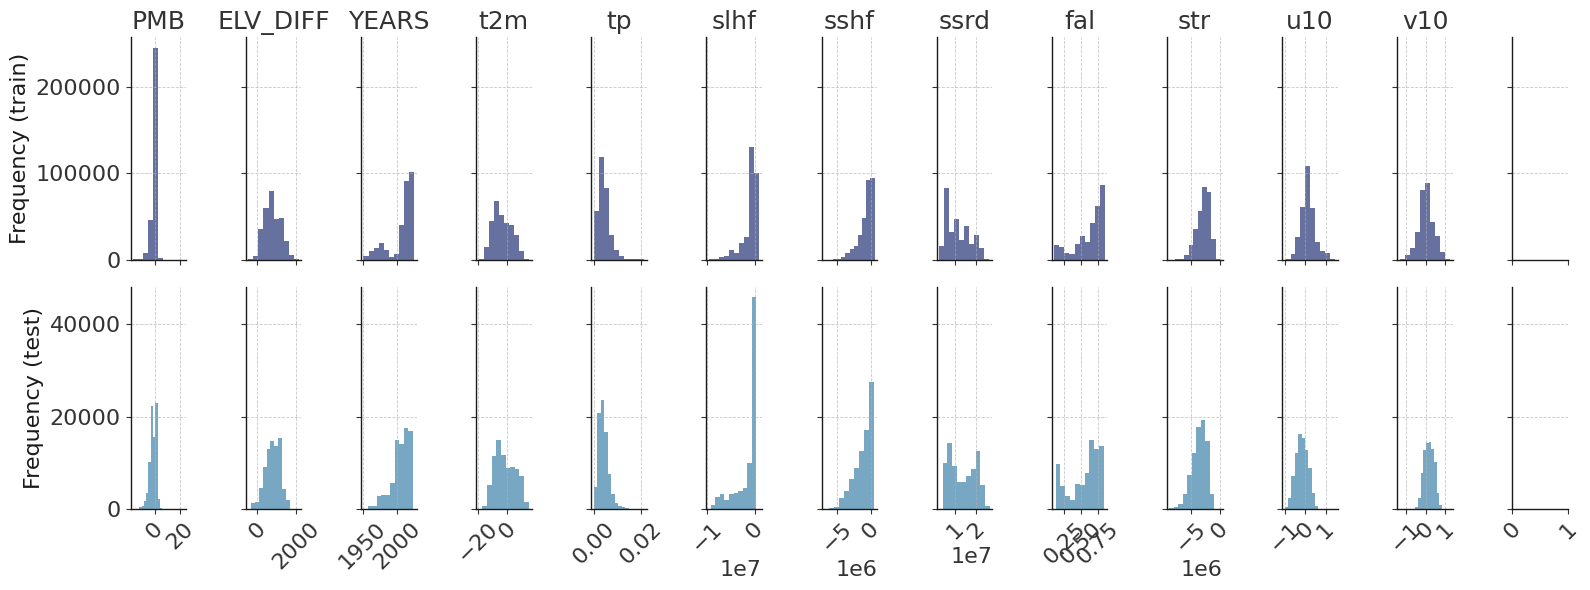

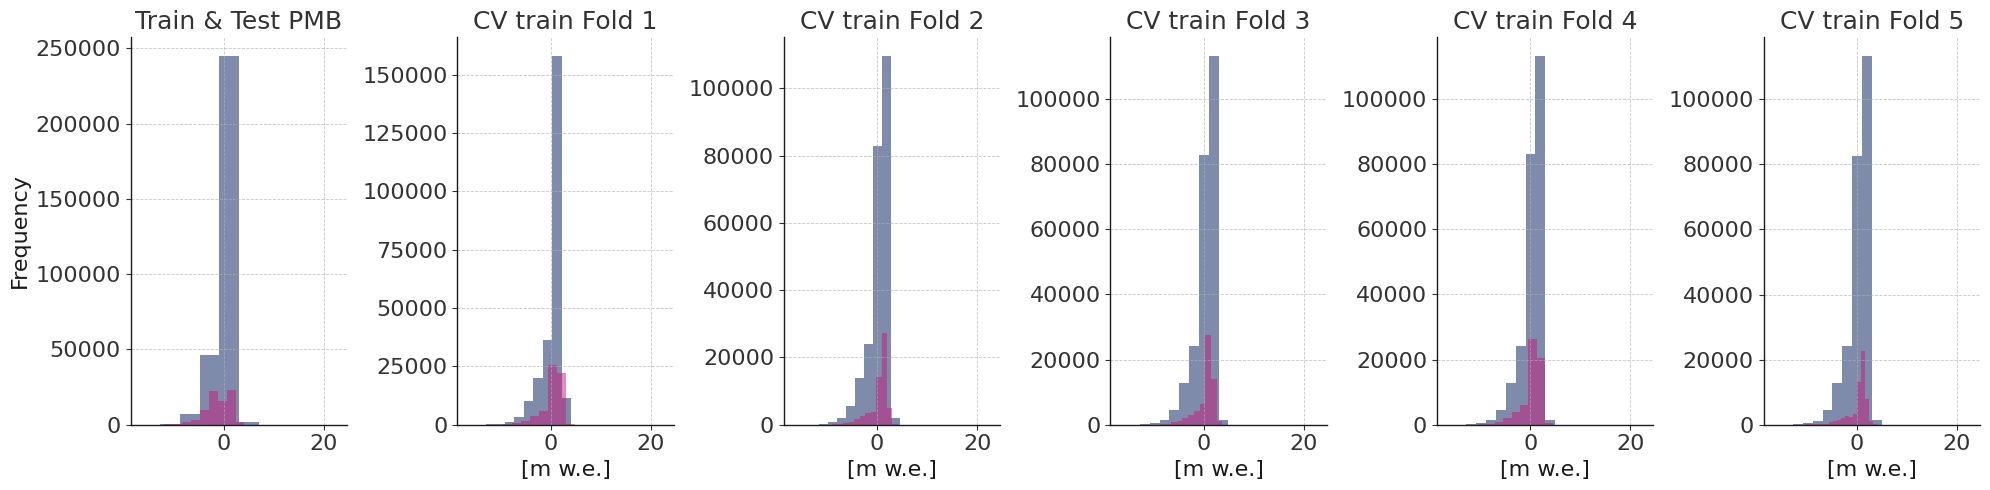

In [16]:
# Train set (Swiss data)
df_X_train = data_monthly_CH
y_train = df_X_train['POINT_BALANCE'].values
train_meas_id = df_X_train['ID'].unique()
train_splits = df_X_train['GLACIER'].unique()

# Test set (French data)
df_X_test = data_monthly
y_test = df_X_test['POINT_BALANCE'].values
test_meas_id = df_X_test['ID'].unique()
test_splits = df_X_test['GLACIER'].unique()

test_set = {
    'df_X': df_X_test,
    'y': y_test,
    'meas_id': test_meas_id,
    'splits_vals': test_splits
}

train_set = {
    'df_X': df_X_train,
    'y': y_train,
    'splits_vals': train_splits,
    'meas_id': train_meas_id,
}

# Have to create a dataloader so i can use get_cv_split()
dataloader_CH = mbm.DataLoader(cfg, 
                              data=data_monthly_CH,
                              random_seed=cfg.seed,
                              meta_data_columns=cfg.metaData)


train_indices = data_monthly_CH.index
test_indices = pd.Index([]) 

dataloader_CH.set_custom_train_test_indices(train_indices, test_indices)


splits = dataloader_CH.get_cv_split(n_splits=5, type_fold='group-meas-id')

print('Test glaciers in FR: ({}) {}'.format(len(test_set['splits_vals']), test_set['splits_vals']))
print('Train glaciers in CH: ({}) {}'.format(len(train_set['splits_vals']), train_set['splits_vals']))

print('Size of test set:', len(test_set['df_X']))
print('Size of train set:', len(train_set['df_X']))


visualiseInputs(train_set, test_set, vois_climate)
visualiseSplits(test_set['y'], train_set['y'], splits)

Text(0.5, 1.02, 'Feature Distributions: Training Set vs Test Glaciers')

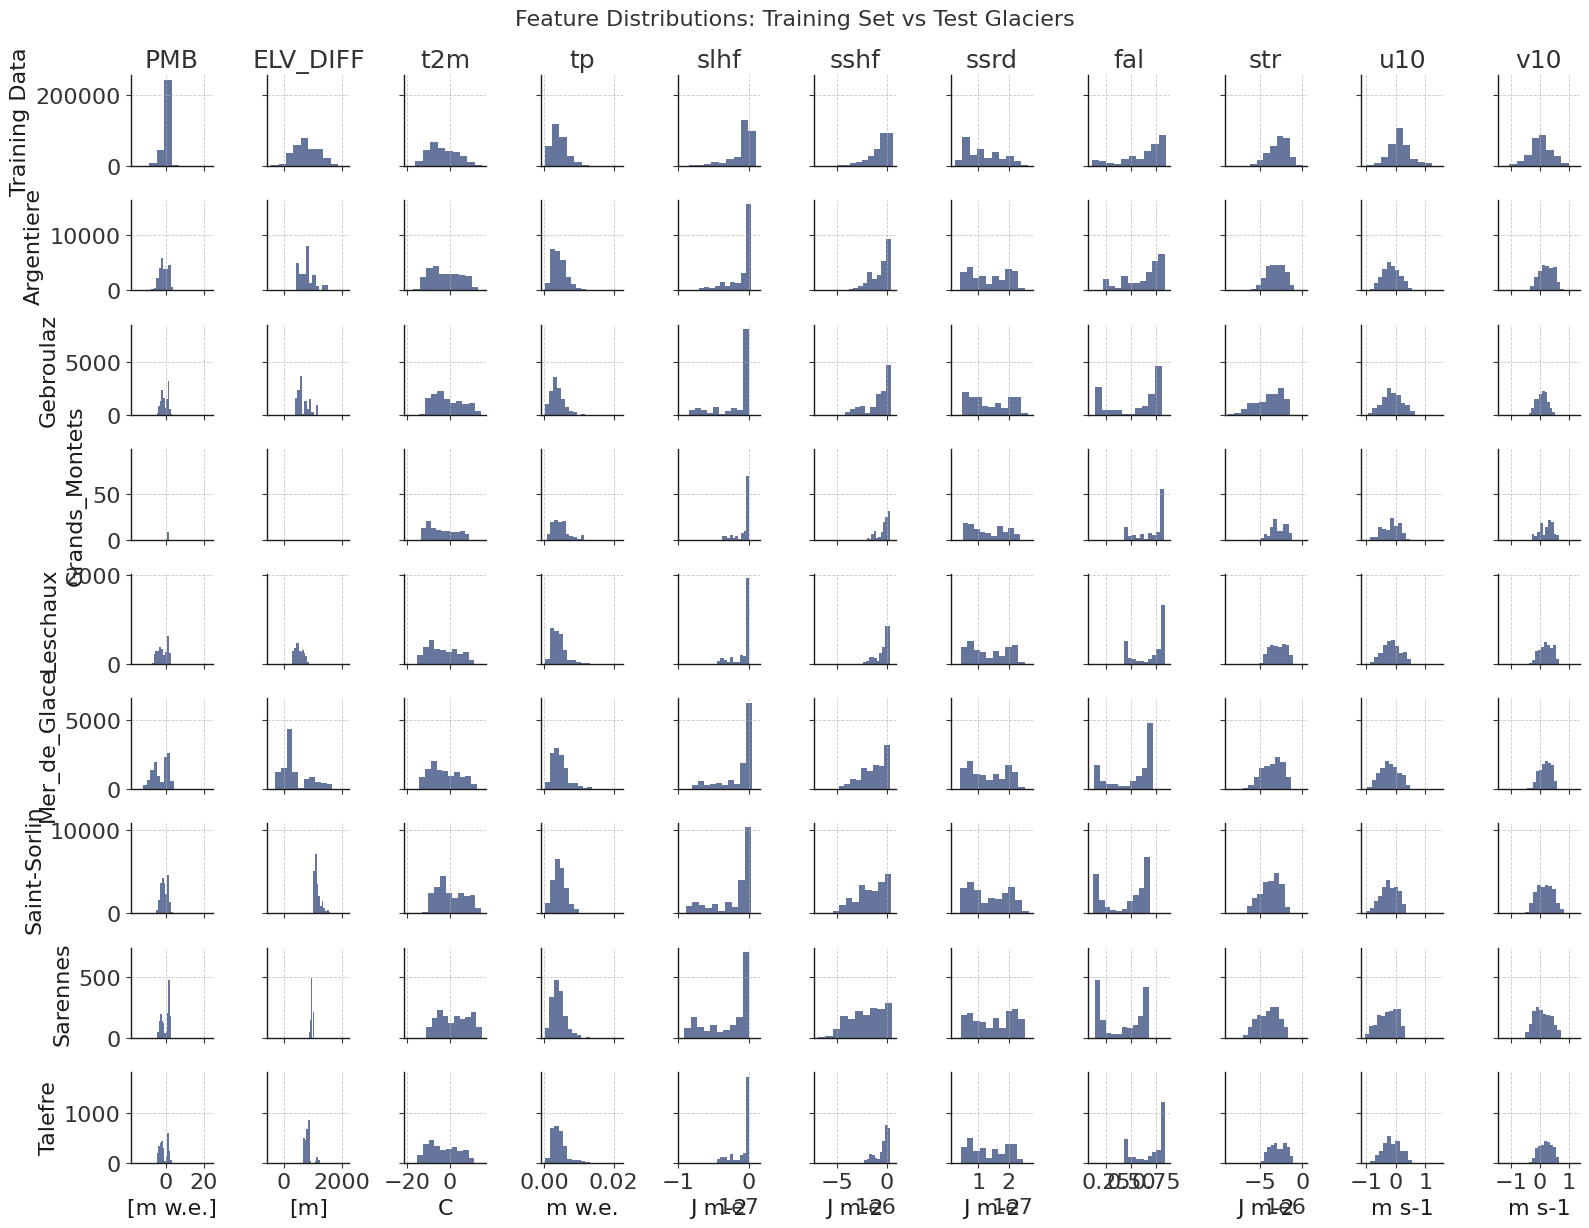

In [17]:
test_glaciers = test_splits

# Plot distributions of test glaciers with train data as first row
n_rows = len(test_glaciers) + 1 
f, ax = plt.subplots(n_rows,
                     len(vois_climate) + 2,
                     figsize=(16, 12),
                     sharey='row',
                     sharex='col')

# Plot the training data in the first row
train_df = train_set['df_X']  # All training data
train_df['POINT_BALANCE'].plot.hist(ax=ax[0, 0],
                                    color=color_xgb,  # Use same color as in visualiseInputs
                                    alpha=0.6,
                                    density=False)
ax[0, 0].set_title('PMB')
ax[0, 0].set_ylabel('Training Data')
ax[0, 0].set_xlabel('[m w.e.]')

train_df['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[0, 1],
                                           color=color_xgb,
                                           alpha=0.6,
                                           density=False)
ax[0, 1].set_title('ELV_DIFF')
ax[0, 1].set_xlabel('[m]')

for j, voi_clim in enumerate(vois_climate):
    ax[0, 2 + j].set_title(voi_clim)
    train_df[voi_clim].plot.hist(ax=ax[0, 2 + j],
                                 color=color_xgb,
                                 alpha=0.6,
                                 density=False)
    ax[0, 2 + j].set_xlabel(vois_units[voi_clim])

# Plot the test glaciers
for i, test_gl in enumerate(test_glaciers):
    row_idx = i + 1  # Offset by 1 for the training data row
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[row_idx, 0],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
    ax[row_idx, 0].set_ylabel(test_gl)
    ax[row_idx, 0].set_xlabel('[m w.e.]')
    
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[row_idx, 1],
                                                 color=color_dark_blue,
                                                 alpha=0.6,
                                                 density=False)
    ax[row_idx, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate):
        test_df_gl[voi_clim].plot.hist(ax=ax[row_idx, 2 + j],
                                       color=color_dark_blue,
                                       alpha=0.6,
                                       density=False)
        ax[row_idx, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()
plt.suptitle('Feature Distributions: Training Set vs Test Glaciers', 
             fontsize=16, y=1.02)

"Available variables and their corresponding var_labels:\n\n    Point Mass Balance:\n    - 'POINT_BALANCE' → 'PMB [m w.e.]'\n\n    Elevation:\n    - 'ELEVATION_DIFFERENCE' → 'Elevation Difference [m]'\n    - 'POINT_ELEVATION' → 'Elevation [m]'\n    - 'ALTITUDE_CLIMATE' → 'Climate Altitude [m]'\n\n    Climate Variables:\n    - 't2m' → 'Temperature [K]'\n    - 'tp' → 'Precipitation [mm]'\n    - 'slhf' → 'Surface Latent Heat Flux [W/m²]'\n    - 'sshf' → 'Surface Sensible Heat Flux [W/m²]'\n    - 'ssrd' → 'Surface Solar Radiation Downward [W/m²]'\n    - 'fal' → 'Forecast Albedo [-]'\n    - 'str' → 'Surface Thermal Radiation [W/m²]'\n    - 'u10' → 'Wind E [m/s]'\n    - 'v10' → 'Wind N [m/s]'\n\n    Topographical Variables:\n    - 'aspect' → 'Aspect [degrees]'\n    - 'slope' → 'Slope [degrees]'\n    - 'hugonnet_dhdt' → 'Ice Thickness Change Rate [m/yr]'\n    - 'consensus_ice_thickness' → 'Ice Thickness [m]'\n    - 'millan_v' → 'Ice Velocity [m/yr]'"

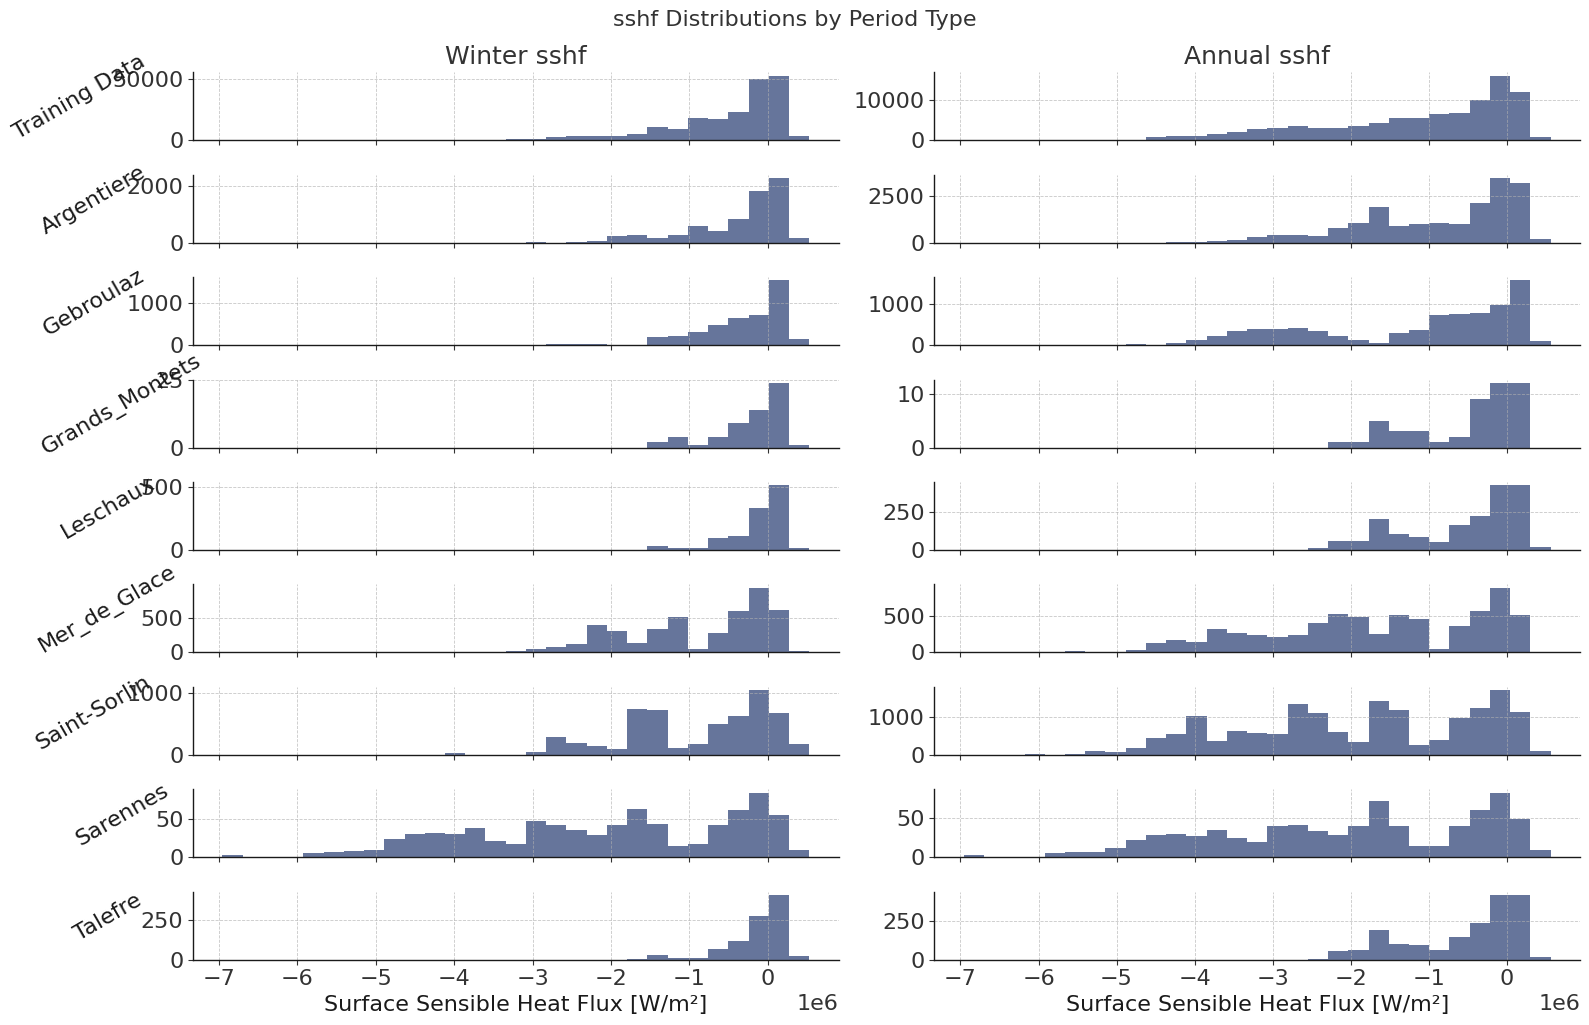

In [18]:
def plot_combined_distributions(test_glaciers, train_set, test_set, color_xgb, color_dark_blue, 
                               variable='POINT_BALANCE', var_label='PMB [m w.e.]',
                               period_titles=None):
    """
    Plot distributions of any variable for winter and annual periods.

    """
    # Set up plot with 2 columns - Winter and Annual
    n_rows = len(test_glaciers) + 1
    fig, axs = plt.subplots(n_rows, 2, figsize=(16, 10), sharex='col')
    
    periods = ['winter', 'annual']
    if period_titles is None:
        period_titles = [f'Winter {variable}', f'Annual {variable}']
    
    # For each period (column)
    for col, (period, title) in enumerate(zip(periods, period_titles)):
        # Filter by period
        train_df = train_set['df_X'][train_set['df_X']['PERIOD'] == period]
        
        # Calculate common bins for this period
        all_values = train_df[variable].values
        for test_gl in test_glaciers:
            test_df = test_set['df_X'][(test_set['df_X']['GLACIER'] == test_gl) & 
                                      (test_set['df_X']['PERIOD'] == period)]
            if len(test_df) > 0:
                all_values = np.concatenate([all_values, test_df[variable].values])
        
        if len(all_values) > 0:  # Check if there's data for this period
            bins = np.linspace(np.floor(min(all_values)), np.ceil(max(all_values)), 30)
            
            # Add column title
            axs[0, col].set_title(title)
            
            # Training data histogram (first row)
            train_df[variable].plot.hist(ax=axs[0, col], 
                                       color=color_xgb, 
                                       alpha=0.6, 
                                       bins=bins)

            # Remove "Frequency" y-axis label
            axs[0, col].set_ylabel("")
            
            # Only add y-label on the first column
            if col == 0:
                axs[0, col].set_ylabel('Training Data', rotation=30, labelpad=20)
            
            # Test glaciers histograms (subsequent rows)
            for i, glacier in enumerate(test_glaciers):
                row_idx = i + 1  # Offset by 1 for the training data row
                test_df = test_set['df_X'][(test_set['df_X']['GLACIER'] == glacier) & 
                                          (test_set['df_X']['PERIOD'] == period)]
                
                test_df[variable].plot.hist(ax=axs[row_idx, col], 
                                          color=color_dark_blue, 
                                          alpha=0.6, 
                                          bins=bins)

                # Remove "Frequency" y-axis label
                axs[row_idx, col].set_ylabel("")
                
                # Only add y-label on the first column
                if col == 0:
                    axs[row_idx, col].set_ylabel(glacier, rotation=30, labelpad=20)
    
    # Add x-axis labels for the bottom row AFTER all plotting is done
    for col in range(2):
        axs[-1, col].set_xlabel(var_label)
    
    fig.tight_layout()
    fig.suptitle(f'{variable} Distributions by Period Type', fontsize=16, y=1.02)
    
    return fig

# Example usage with the variable and label explicitly set
fig = plot_combined_distributions(test_glaciers, train_set, test_set, color_xgb, color_dark_blue, 
                          variable='sshf', var_label='Surface Sensible Heat Flux [W/m²]')

"""Available variables and their corresponding var_labels:

    Point Mass Balance:
    - 'POINT_BALANCE' → 'PMB [m w.e.]'

    Elevation:
    - 'ELEVATION_DIFFERENCE' → 'Elevation Difference [m]'
    - 'POINT_ELEVATION' → 'Elevation [m]'
    - 'ALTITUDE_CLIMATE' → 'Climate Altitude [m]'

    Climate Variables:
    - 't2m' → 'Temperature [K]'
    - 'tp' → 'Precipitation [mm]'
    - 'slhf' → 'Surface Latent Heat Flux [W/m²]'
    - 'sshf' → 'Surface Sensible Heat Flux [W/m²]'
    - 'ssrd' → 'Surface Solar Radiation Downward [W/m²]'
    - 'fal' → 'Forecast Albedo [-]'
    - 'str' → 'Surface Thermal Radiation [W/m²]'
    - 'u10' → 'Wind E [m/s]'
    - 'v10' → 'Wind N [m/s]'

    Topographical Variables:
    - 'aspect' → 'Aspect [degrees]'
    - 'slope' → 'Slope [degrees]'
    - 'hugonnet_dhdt' → 'Ice Thickness Change Rate [m/yr]'
    - 'consensus_ice_thickness' → 'Ice Thickness [m]'
    - 'millan_v' → 'Ice Velocity [m/yr]'"""

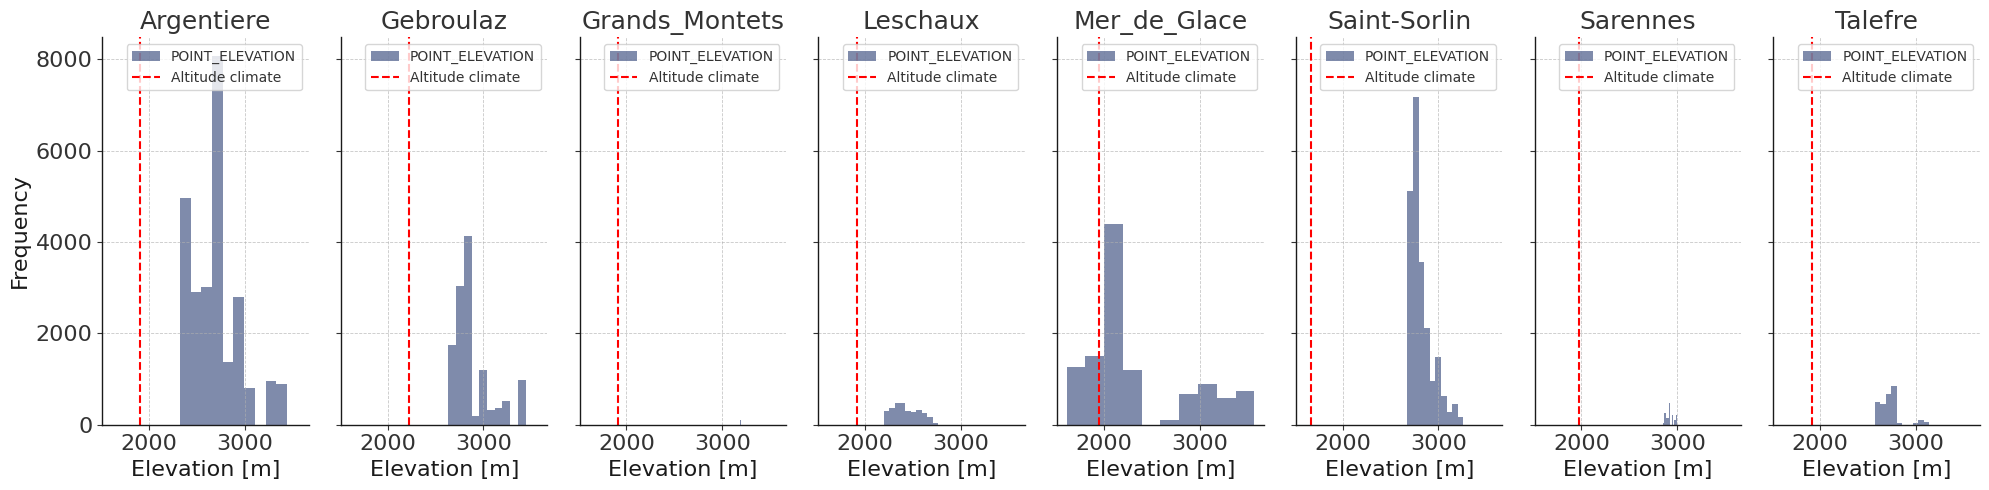

In [19]:
f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

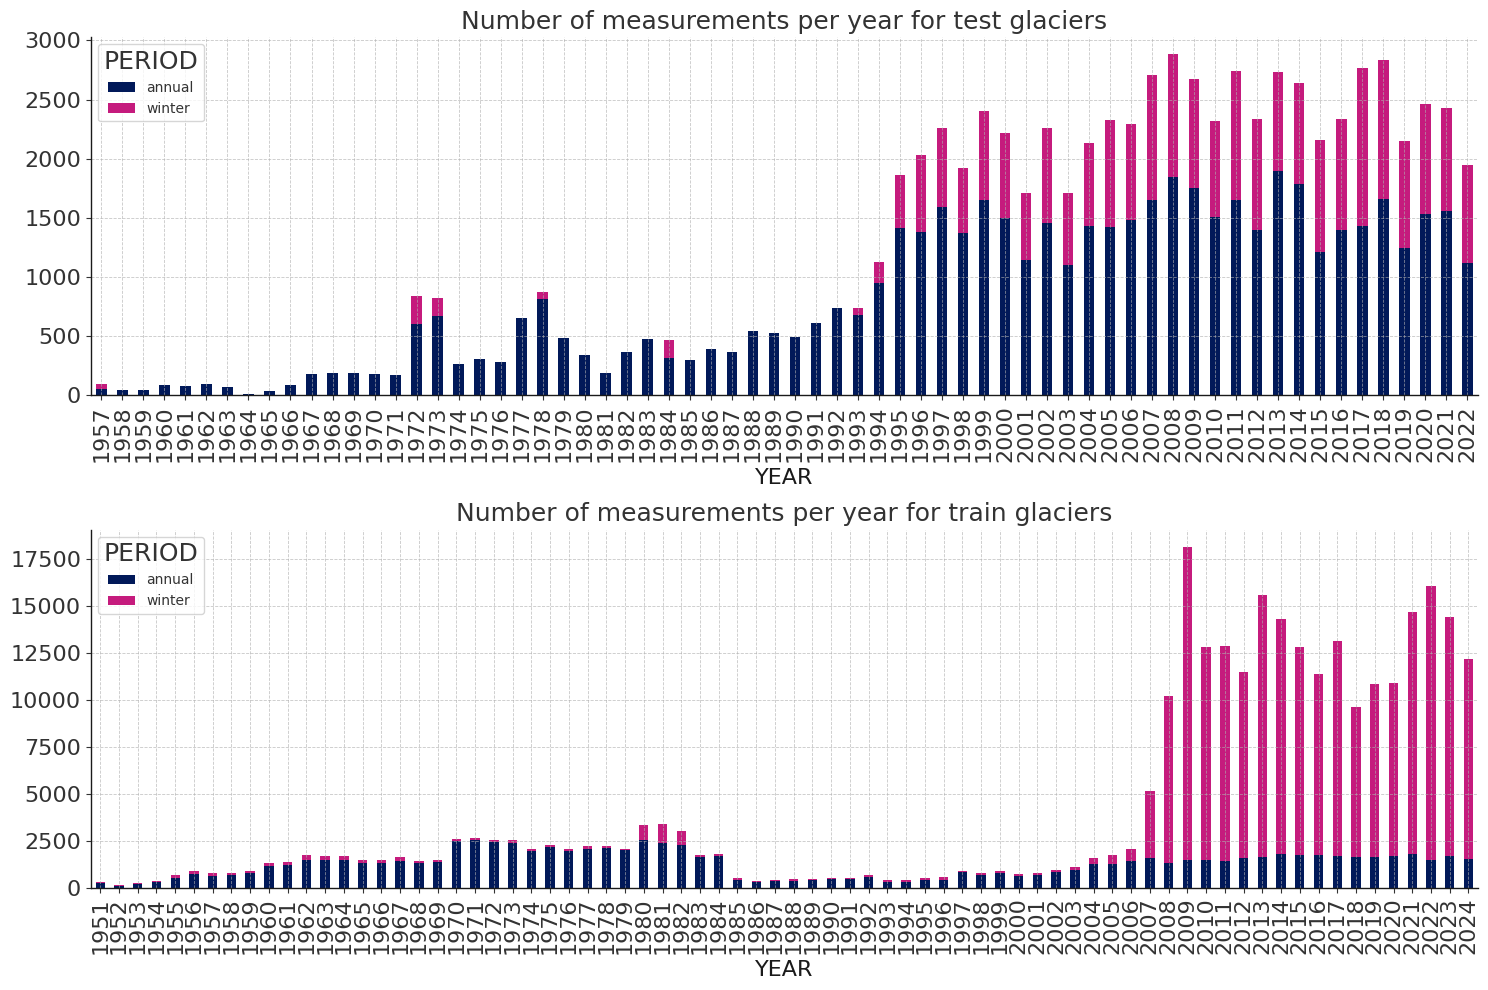

In [20]:
# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
df_X_test.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
df_X_train.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

## XGBoost:

In [24]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

# vois_climate = [
#     't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10',
#     'v10'
# ]

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

### Grid search:

In [25]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'CH_FR_no_summer_newAPI.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_Gebroulaz.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (77412, 27)
Shape of testing dataset: (15006, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v']
Best parameters:
 {'n_estimators': 400, 'max_depth': 2, 'learning_rate': 0.1}
Best score:
 -1.3029484077147906
Shape of the test: (15006, 15)
Overall score: 0.9820285351982057
CPU times: user 2 s, sys: 94.6 ms, total: 2.09 s
Wall time: 179 ms


In [ ]:
# visualiseValPreds(best_estimator, splits, train_set, feature_columns)

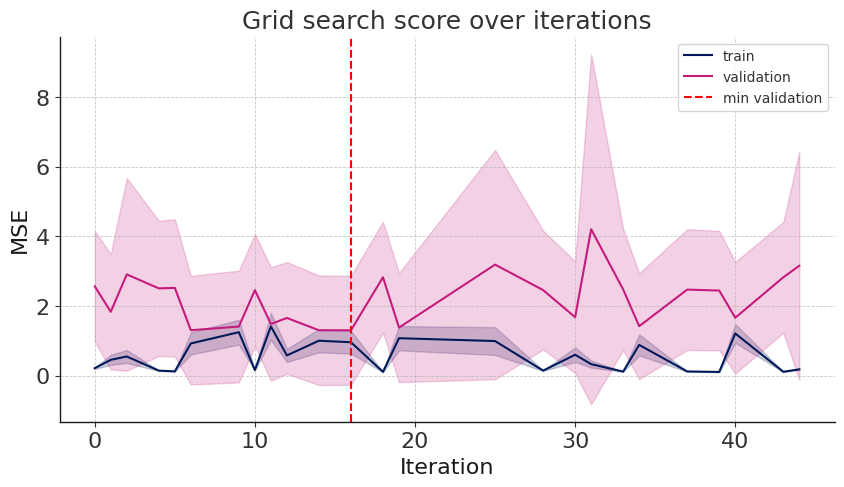

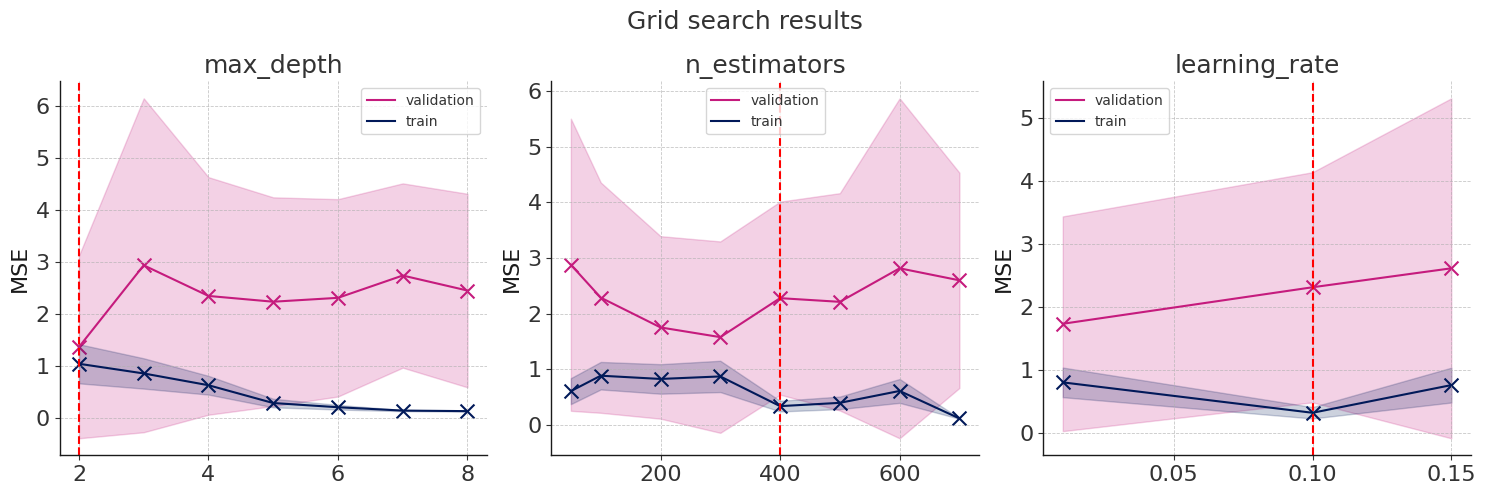

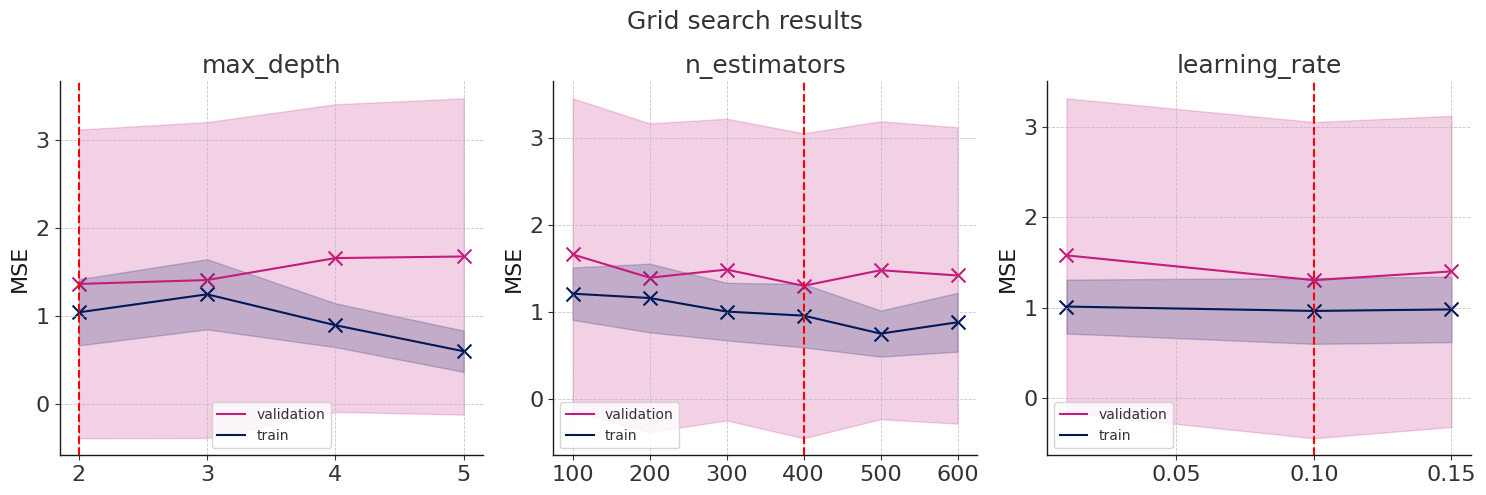

In [26]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

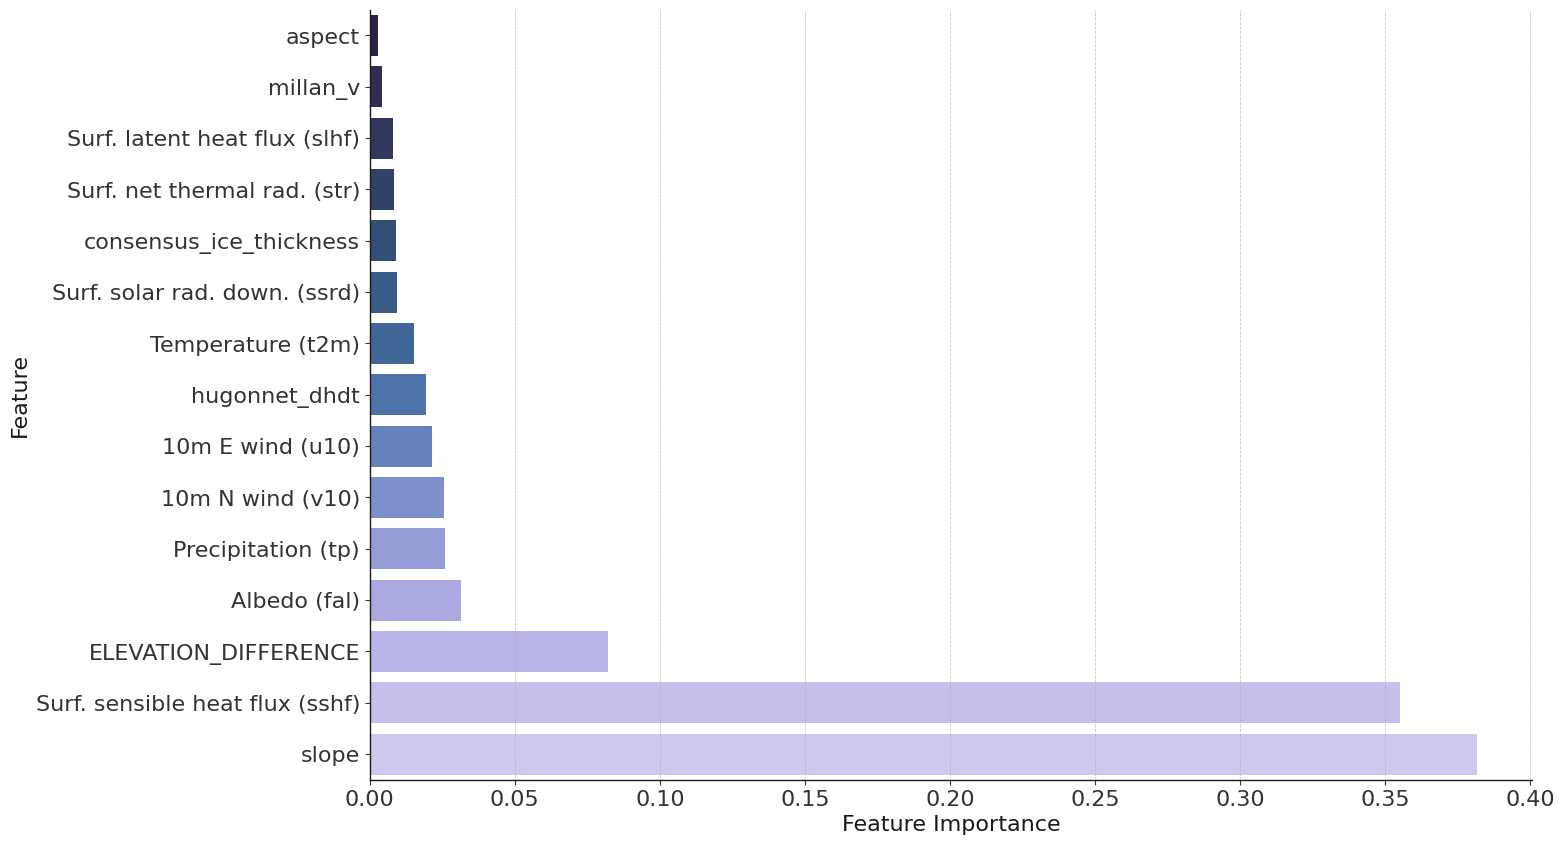

In [27]:
FIPlot(best_estimator, feature_columns, vois_climate)

#### Predictions of best parameters:

Shape of the test: (15006, 15)
{'Gebroulaz': '#a6cee3'}


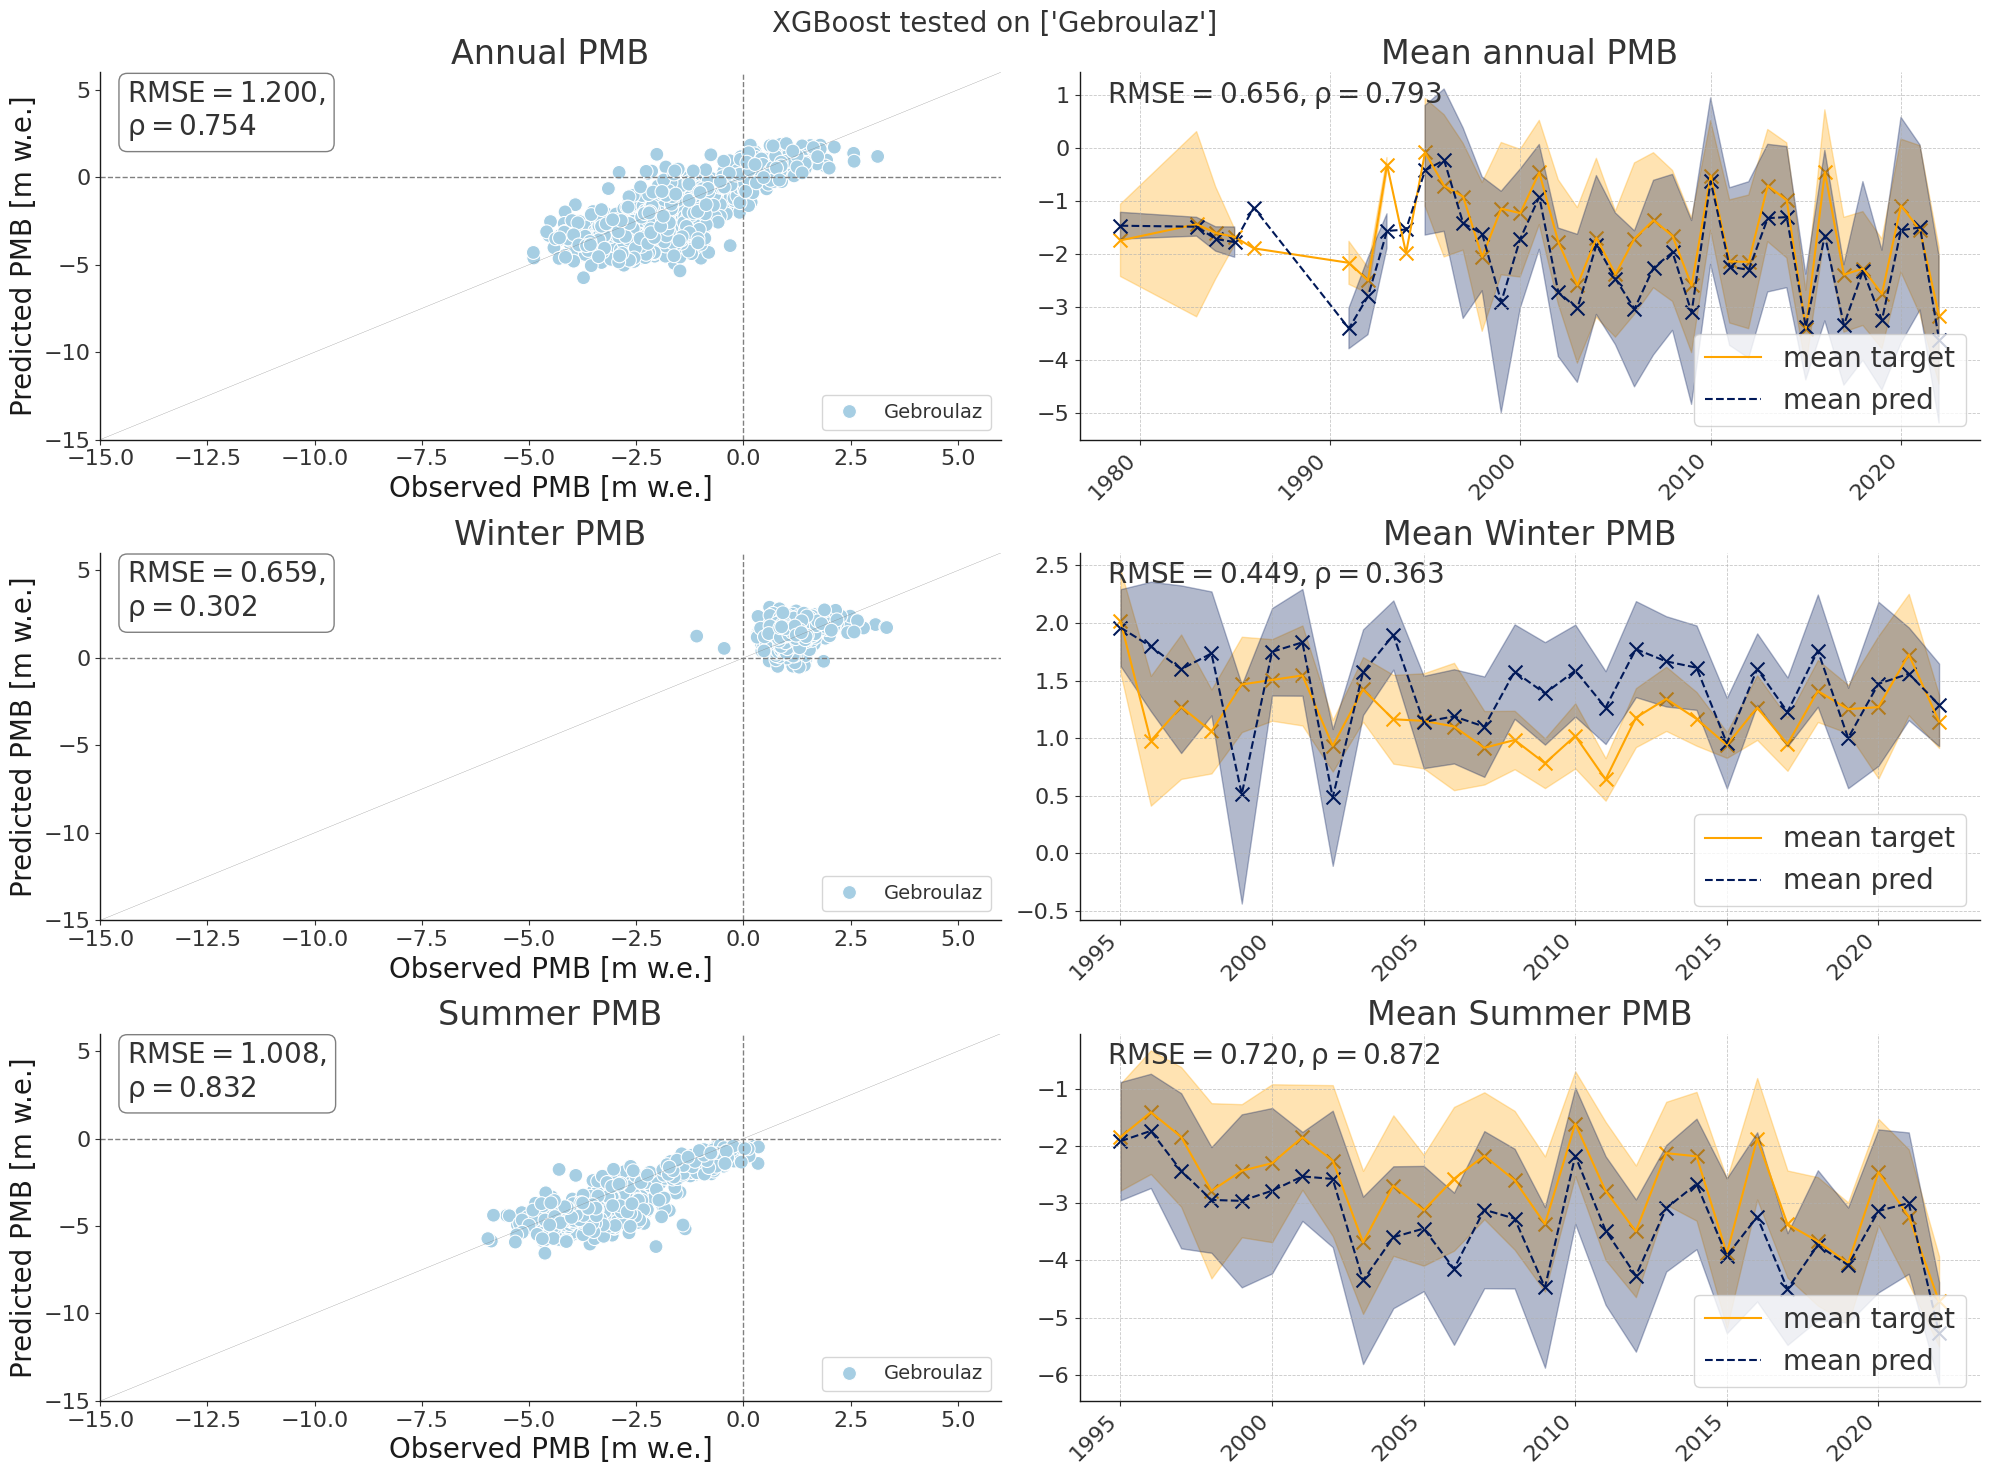

In [28]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

ValueError: The palette dictionary is missing keys: {'summer', 'winter'}

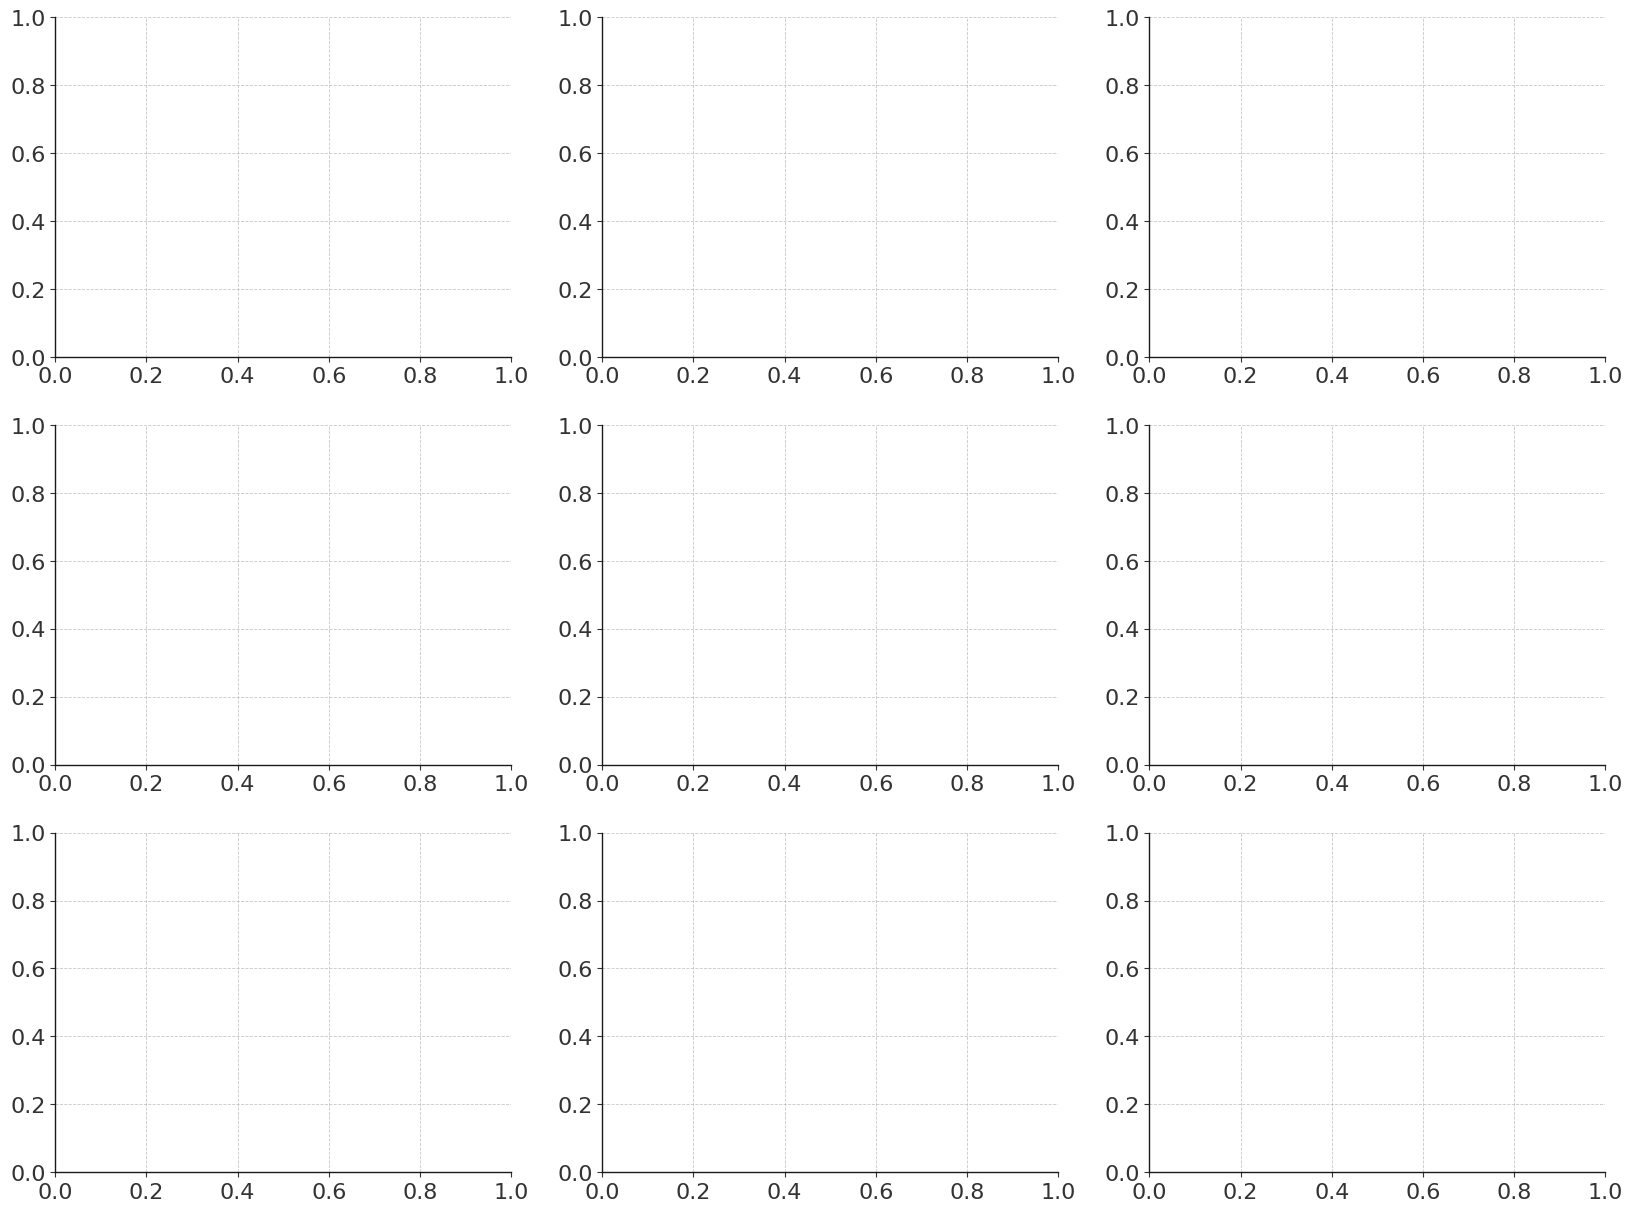

In [29]:
PlotIndividualGlacierPredVsTruth(grouped_ids, figsize=(20, 15))

Text(0.5, 1.02, 'Feature Distributions: Worst Predictions per Glacier')

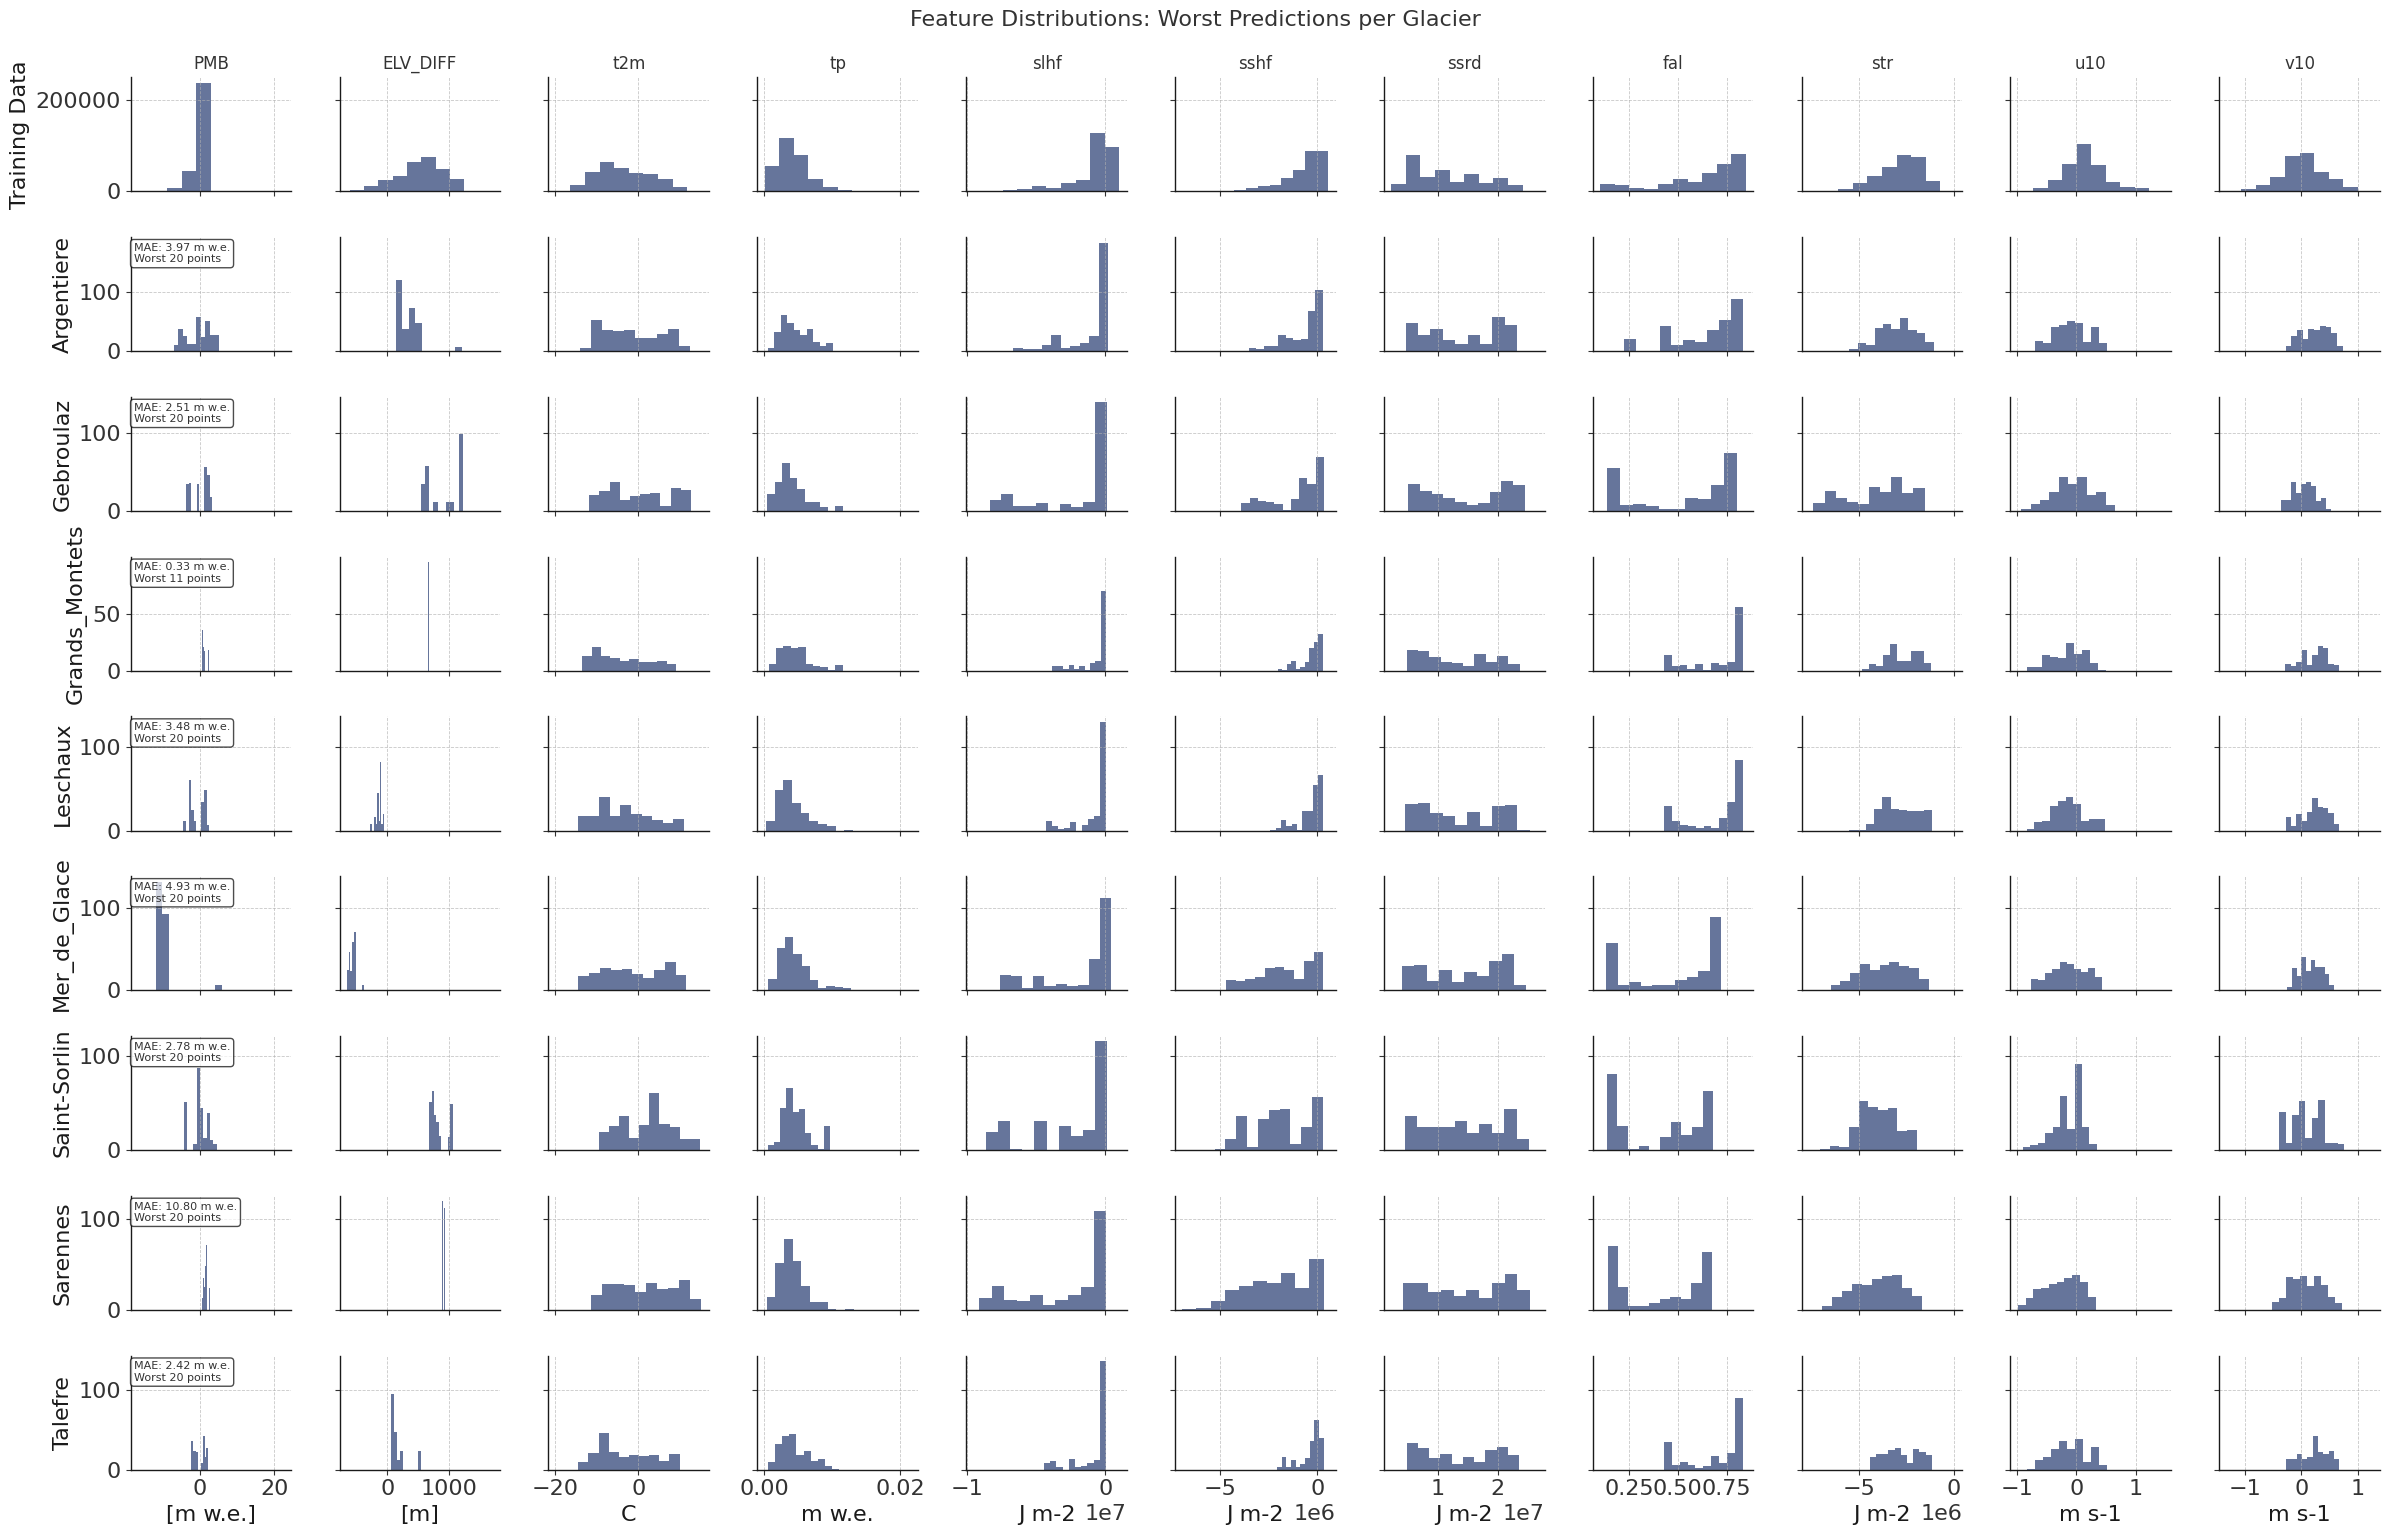

In [29]:
# First, identify the worst predictions for each glacier
def get_worst_n_predictions(df, n=20):
    """Get the n worst predictions for each glacier based on absolute error."""
    # Calculate absolute error
    df['abs_error'] = abs(df['pred'] - df['target'])
    
    # Group by GLACIER and get the n points with the highest error
    worst_points = df.groupby('GLACIER').apply(
        lambda x: x.nlargest(min(n, len(x)), 'abs_error')
    ).reset_index(drop=True)
    
    return worst_points

# Get the worst 20 predictions for each glacier
worst_predictions = get_worst_n_predictions(grouped_ids, n=20)

# Loop through each glacier and create the plot
test_glaciers = worst_predictions['GLACIER'].unique()
n_rows = len(test_glaciers) + 1 
f, ax = plt.subplots(n_rows,
                     len(vois_climate) + 2,
                     figsize=(24, 15),
                     sharey='row',
                     sharex='col')

# Plot the training data in the first row
train_df = train_set['df_X']
train_df['POINT_BALANCE'].plot.hist(ax=ax[0, 0],
                                   color=color_xgb,
                                   alpha=0.6,
                                   density=False)
ax[0, 0].set_title('PMB', fontsize=12)
ax[0, 0].set_ylabel('Training Data')
ax[0, 0].set_xlabel('[m w.e.]')

train_df['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[0, 1],
                                         color=color_xgb,
                                         alpha=0.6,
                                         density=False)
ax[0, 1].set_title('ELV_DIFF', fontsize=12)
ax[0, 1].set_xlabel('[m]')

for j, voi_clim in enumerate(vois_climate):
    ax[0, 2 + j].set_title(voi_clim, fontsize=12)
    train_df[voi_clim].plot.hist(ax=ax[0, 2 + j],
                               color=color_xgb,
                               alpha=0.6,
                               density=False)
    ax[0, 2 + j].set_xlabel(vois_units[voi_clim])

# Plot each glacier's worst predictions
for i, test_gl in enumerate(test_glaciers):
    row_idx = i + 1
    
    # Get the worst point IDs for this glacier
    worst_gl_points = worst_predictions[worst_predictions['GLACIER'] == test_gl]['POINT_ID'].values
    
    # Filter test_set data to only include these worst points
    test_df_gl = test_set['df_X'][test_set['df_X']['POINT_ID'].isin(worst_gl_points)]
    
    # If we have data for this glacier's worst points, plot it
    if len(test_df_gl) > 0:
        test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[row_idx, 0],
                                             color=color_dark_blue,
                                             alpha=0.6,
                                             density=False)
        
        # Calculate mean error but add it to a text box instead of cluttering the y-label
        errors = worst_predictions[worst_predictions['GLACIER'] == test_gl]['abs_error']
        mean_error = errors.mean()
        
        # Just use glacier name as y-label
        ax[row_idx, 0].set_ylabel(test_gl)
        
        # Add error info as text annotation on the first subplot
        ax[row_idx, 0].text(0.02, 0.95, 
                          f"MAE: {mean_error:.2f} m w.e.\nWorst {len(worst_gl_points)} points",
                          transform=ax[row_idx, 0].transAxes,
                          fontsize=8,
                          verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        ax[row_idx, 0].set_xlabel('[m w.e.]')
        
        test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[row_idx, 1],
                                                    color=color_dark_blue,
                                                    alpha=0.6,
                                                    density=False)
        ax[row_idx, 1].set_xlabel('[m]')

        for j, voi_clim in enumerate(vois_climate):
            test_df_gl[voi_clim].plot.hist(ax=ax[row_idx, 2 + j],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
            ax[row_idx, 2 + j].set_xlabel(vois_units[voi_clim])
    else:
        # If no data found for this glacier, add a text message
        ax[row_idx, 0].text(0.5, 0.5, "No data found for worst predictions", 
                          ha='center', va='center', transform=ax[row_idx, 0].transAxes)
        ax[row_idx, 0].set_ylabel(test_gl)

# Improved layout with more width
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Added wspace for more horizontal spacing between subplots
plt.suptitle('Feature Distributions: Worst Predictions per Glacier', 
            fontsize=16, y=1.02)

In [ ]:
def show_worst_prediction_details(grouped_ids, test_set, n=20):
    """
    Shows the details of the worst n predictions for each glacier.
    
    Parameters:
    -----------
    grouped_ids : DataFrame
        DataFrame with columns 'GLACIER', 'POINT_ID', 'pred', 'target'
    test_set : dict
        Dictionary containing test data with 'df_X' key
    n : int
        Number of worst predictions to show per glacier
    """
    # Get the worst predictions
    worst_predictions = get_worst_n_predictions(grouped_ids, n=n)
    
    # Group by glacier
    glaciers = worst_predictions['GLACIER'].unique()
    
    # Display data for each glacier
    for glacier in glaciers:
        print(f"\n{'='*70}")
        print(f"Worst {n} predictions for glacier: {glacier}")
        print(f"{'='*70}")
        
        # Get point IDs for this glacier's worst predictions
        point_ids = worst_predictions[worst_predictions['GLACIER'] == glacier]['POINT_ID'].values
        
        # Get rows from test_set for these point IDs
        glacier_data = test_set['df_X'][test_set['df_X']['POINT_ID'].isin(point_ids)]
        
        # Display with all rows
        with pd.option_context('display.max_rows', None):
            display(glacier_data)

# After running your model and getting grouped_ids
show_worst_prediction_details(grouped_ids, test_set, n=1)

In [ ]:


#grouped_ids.to_csv('/home/mburlet/scratch/data/DATA_MB/Outputs/CH_FR_predictions.csv', index=True)

display(data_monthly_CH.head(2))

display(data_monthly.head(2))

display (data_monthly[data_monthly['GLACIER'] == 'Mer_de_Glace']['POINT_ELEVATION'].mean())

print(f"Mean elevation of Argentiere: {data_monthly[data_monthly['GLACIER'] == 'Argentiere']['POINT_ELEVATION'].mean():.2f} meters")
print(f"Mean elevation of Gebroulaz: {data_monthly[data_monthly['GLACIER'] == 'Gebroulaz']['POINT_ELEVATION'].mean():.2f} meters")
print(f"Mean elevation of Grands_Montets: {data_monthly[data_monthly['GLACIER'] == 'Grands_Montets']['POINT_ELEVATION'].mean():.2f} meters")
print(f"Mean elevation of Leschaux: {data_monthly[data_monthly['GLACIER'] == 'Leschaux']['POINT_ELEVATION'].mean():.2f} meters")
print(f"Mean elevation of Mer_de_Glace: {data_monthly[data_monthly['GLACIER'] == 'Mer_de_Glace']['POINT_ELEVATION'].mean():.2f} meters")
print(f"Mean elevation of Saint-Sorlin: {data_monthly[data_monthly['GLACIER'] == 'Saint-Sorlin']['POINT_ELEVATION'].mean():.2f} meters")
print(f"Mean elevation of Sarennes: {data_monthly[data_monthly['GLACIER'] == 'Sarennes']['POINT_ELEVATION'].mean():.2f} meters")
print(f"Mean elevation of Talefre: {data_monthly[data_monthly['GLACIER'] == 'Talefre']['POINT_ELEVATION'].mean():.2f} meters")

df_grouped_ids = grouped_ids.copy()


glaciers = df_grouped_ids['GLACIER'].unique()
periods = df_grouped_ids['PERIOD'].unique()

results = []


for glacier in glaciers:
    for period in periods:
        # Filter data for this glacier and period
        filtered_df = df_grouped_ids[(df_grouped_ids['GLACIER'] == glacier) & (df_grouped_ids['PERIOD'] == period)]
        
        errors = filtered_df['pred'] - filtered_df['target']
        
        rmse = np.sqrt(np.mean(errors**2))
        mean_error = np.mean(errors)
        
        results.append({
            'GLACIER': glacier,
            'PERIOD': period,
            'RMSE': rmse,
            'Mean_Error': mean_error,
            'Count': len(filtered_df)
        })

# Convert to dataframe
results_df = pd.DataFrame(results)

display(results_df)

with pd.option_context('display.max_rows', None):
    display(grouped_ids[grouped_ids['GLACIER'] == 'Sarennes'])

### Predictions of custom parameters:

Shape of training dataset: (89125, 27)
Shape of testing dataset: (3582, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v']
{'device': 'cuda:0', 'tree_method': 'hist', 'random_state': 30, 'n_jobs': -1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}
Shape of the test: (3582, 15)
Overall score: 1.864708498483454
{'mdg': '#a6cee3'}


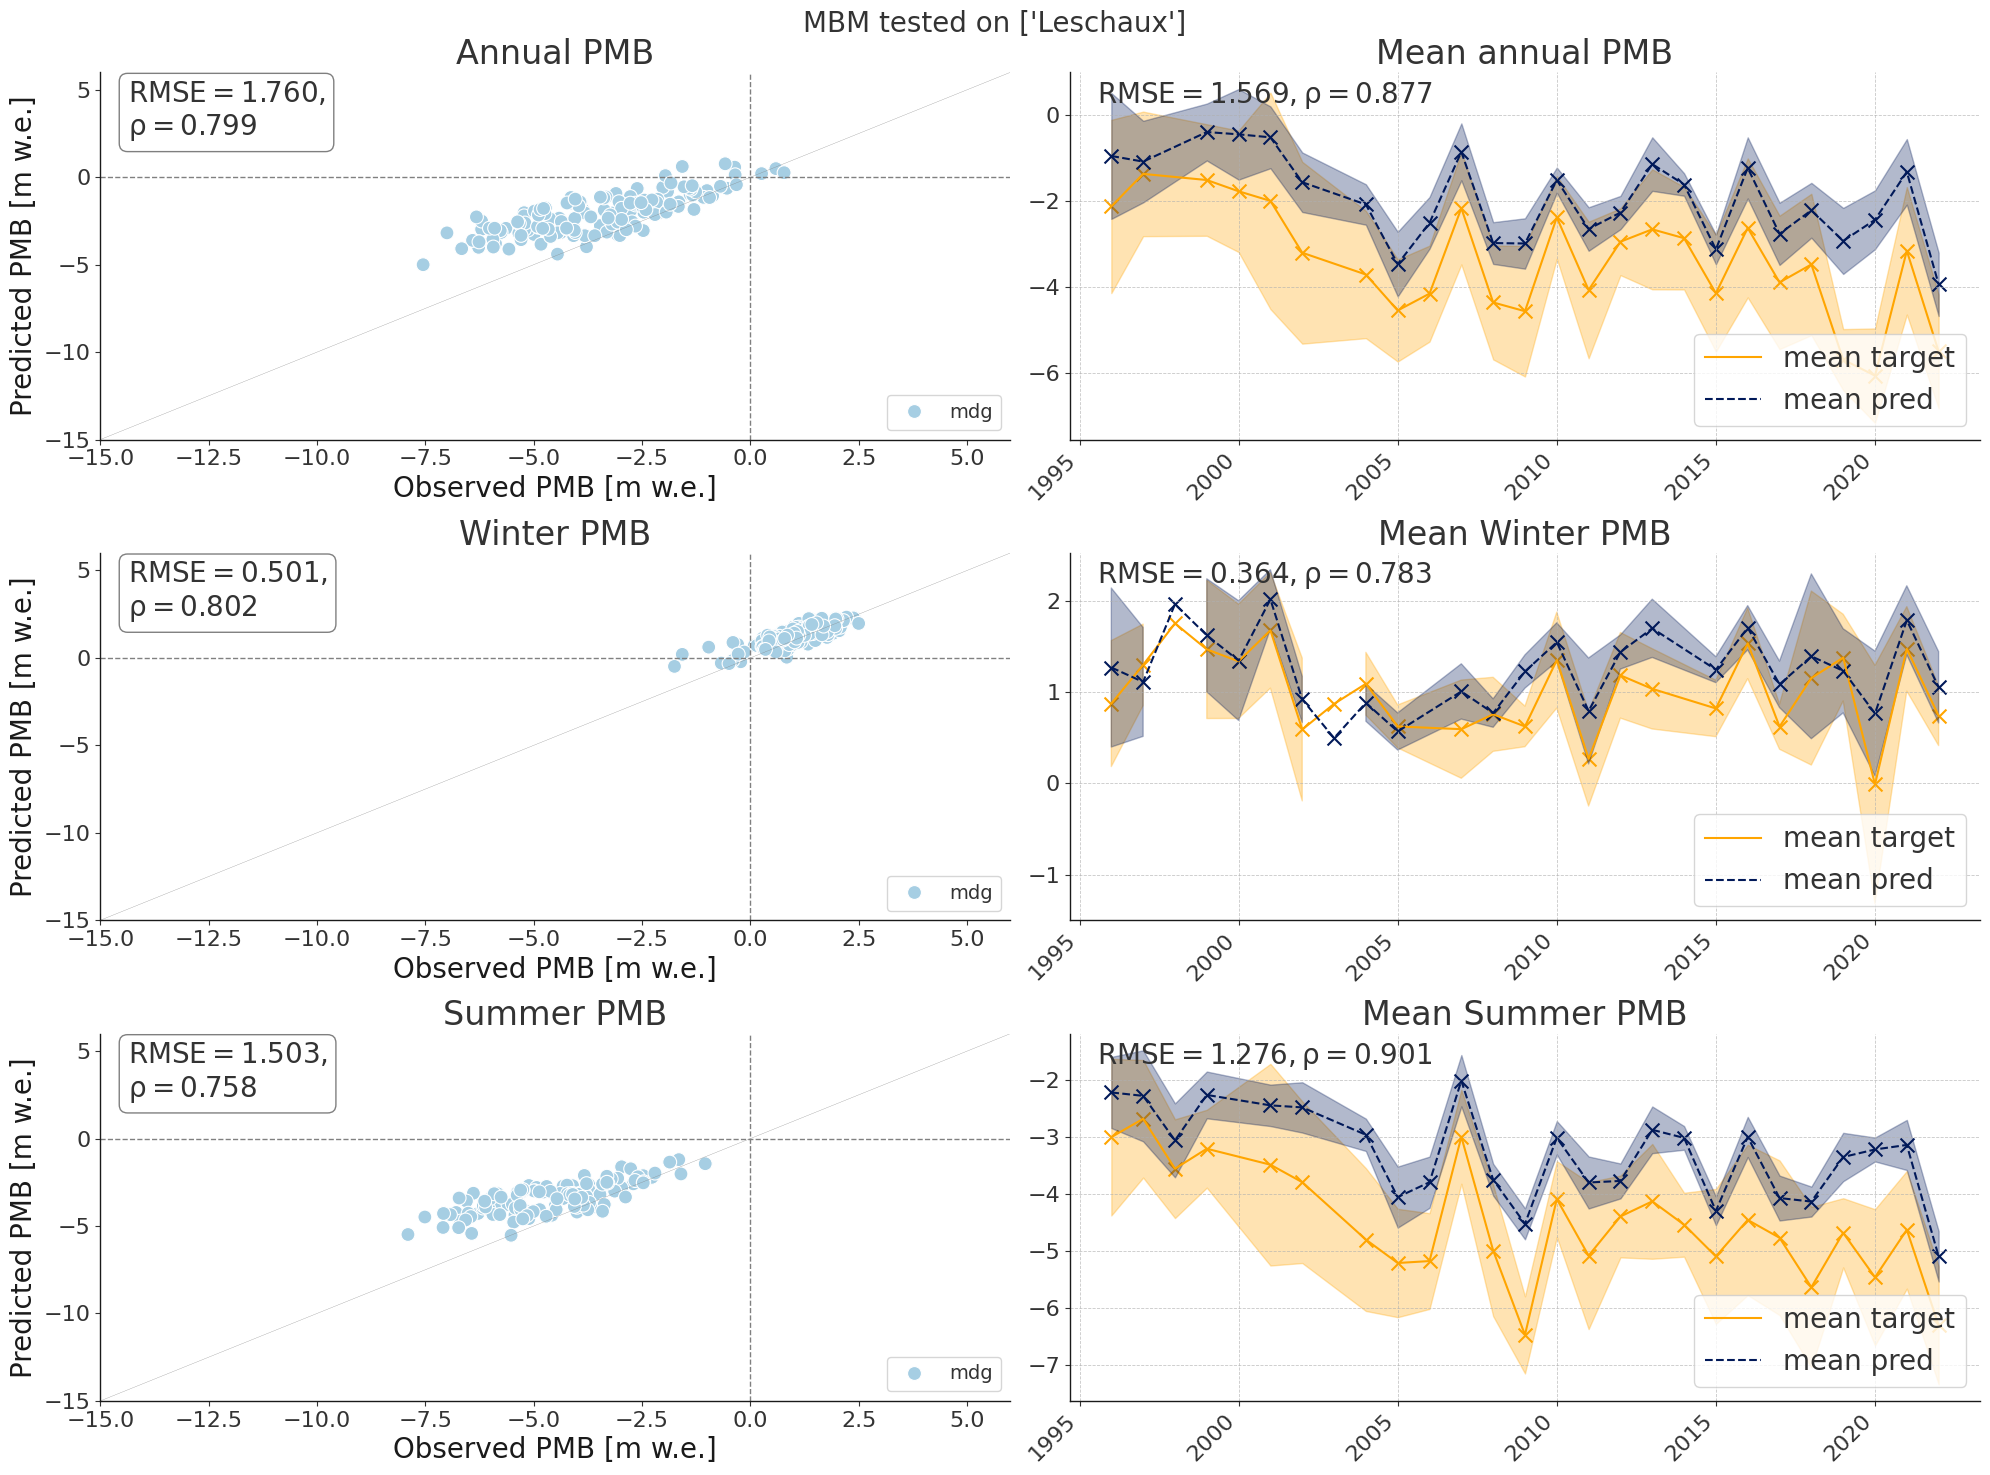

In [34]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

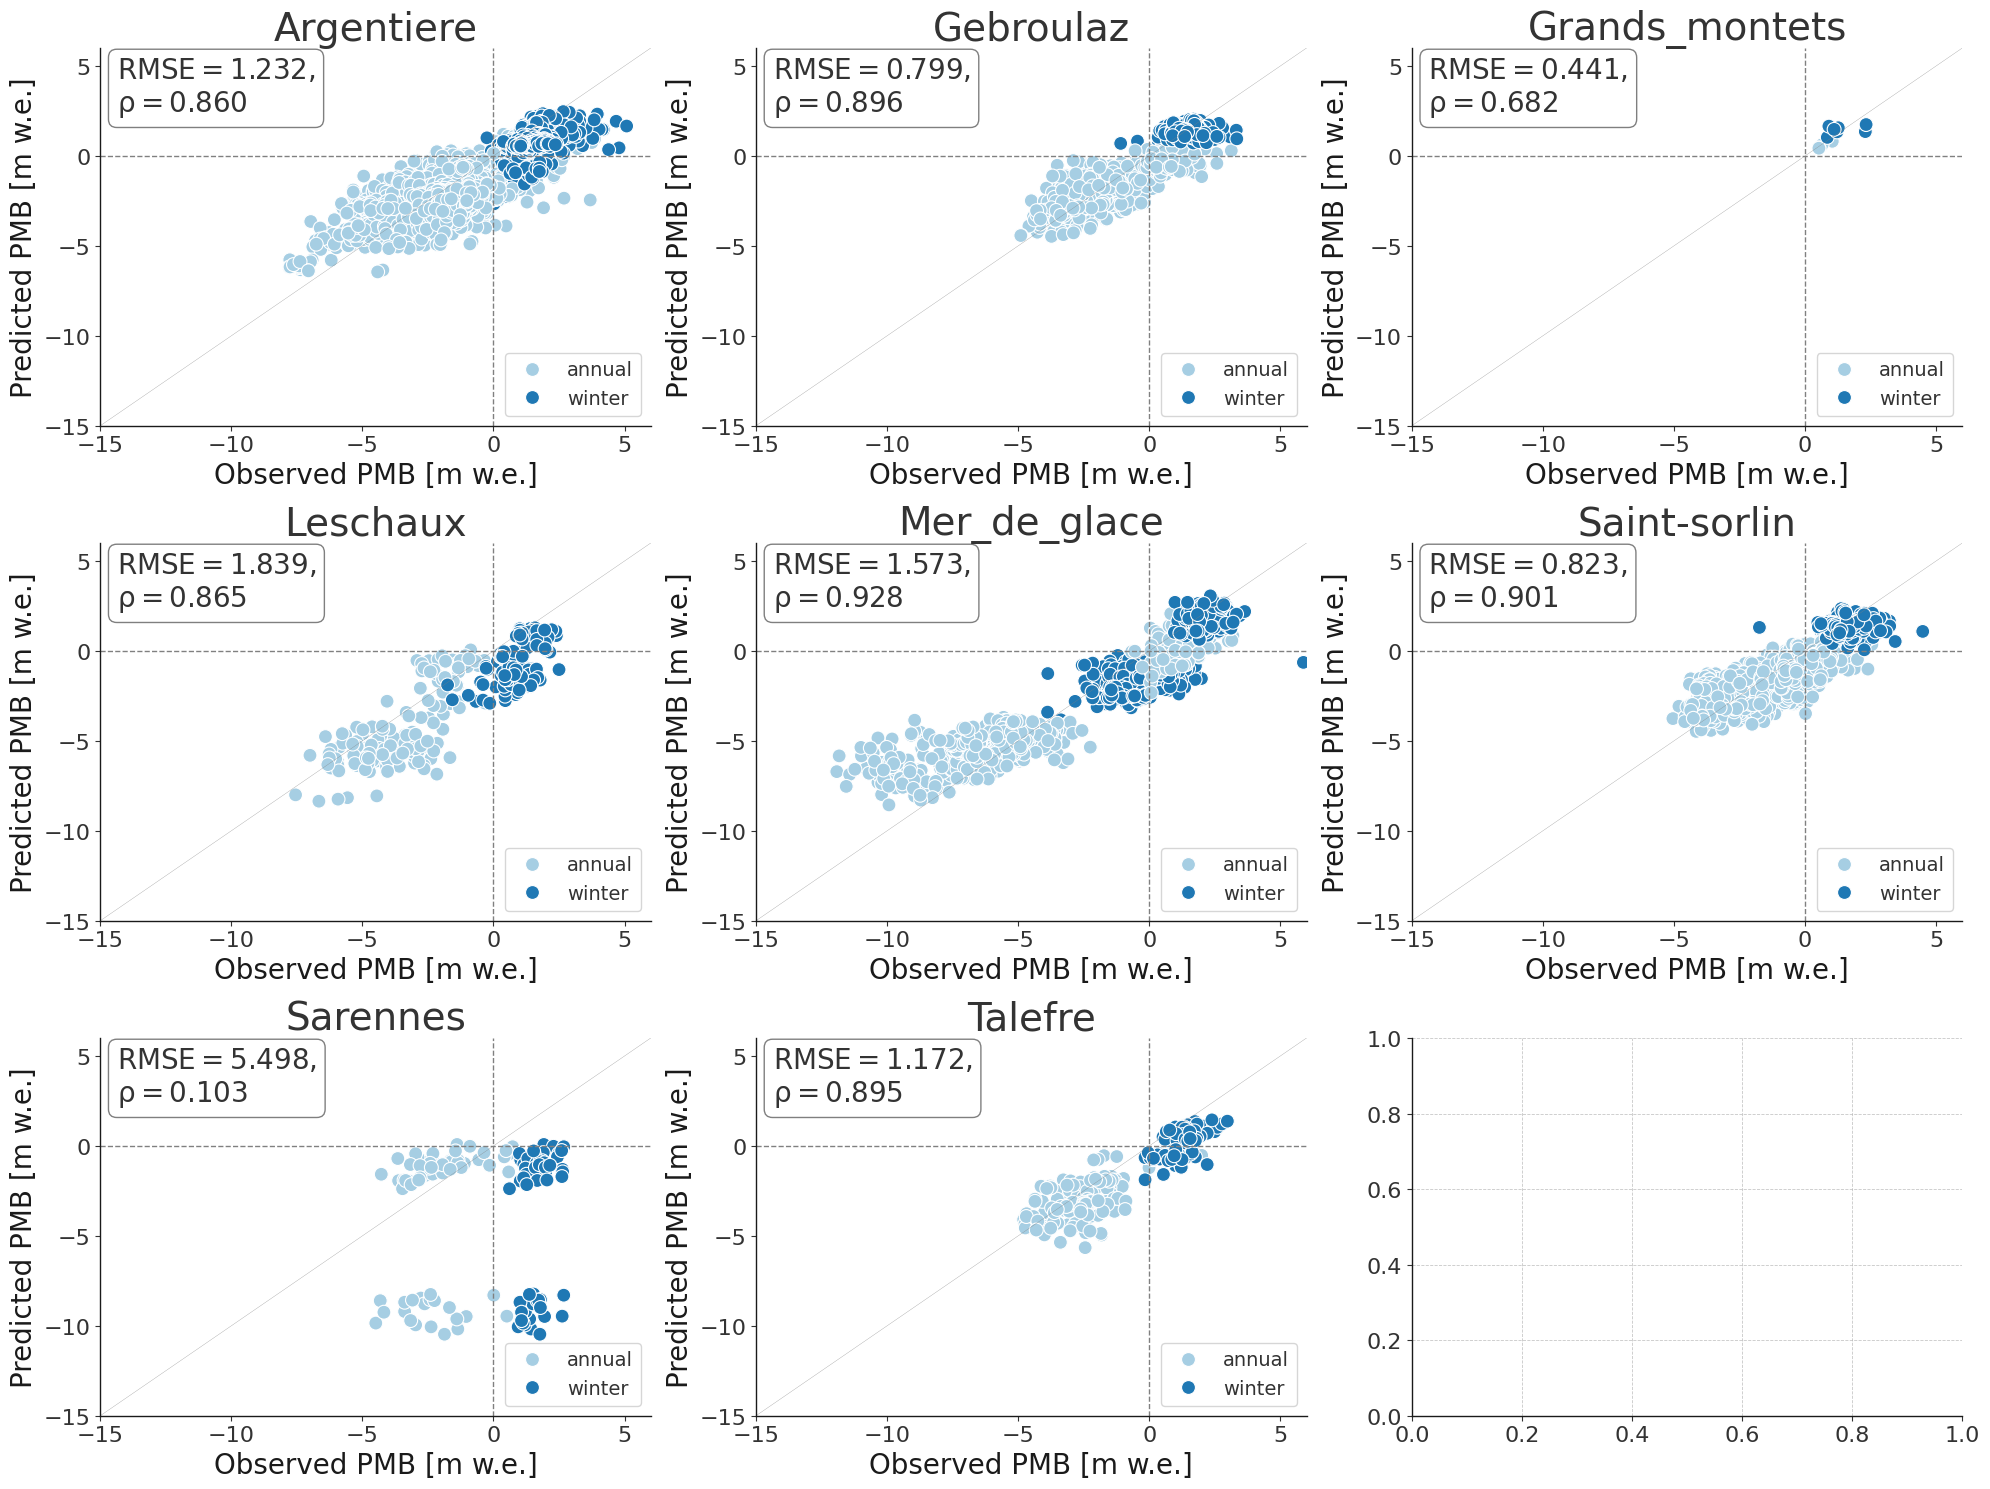

In [35]:
# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, figsize=(20, 15))

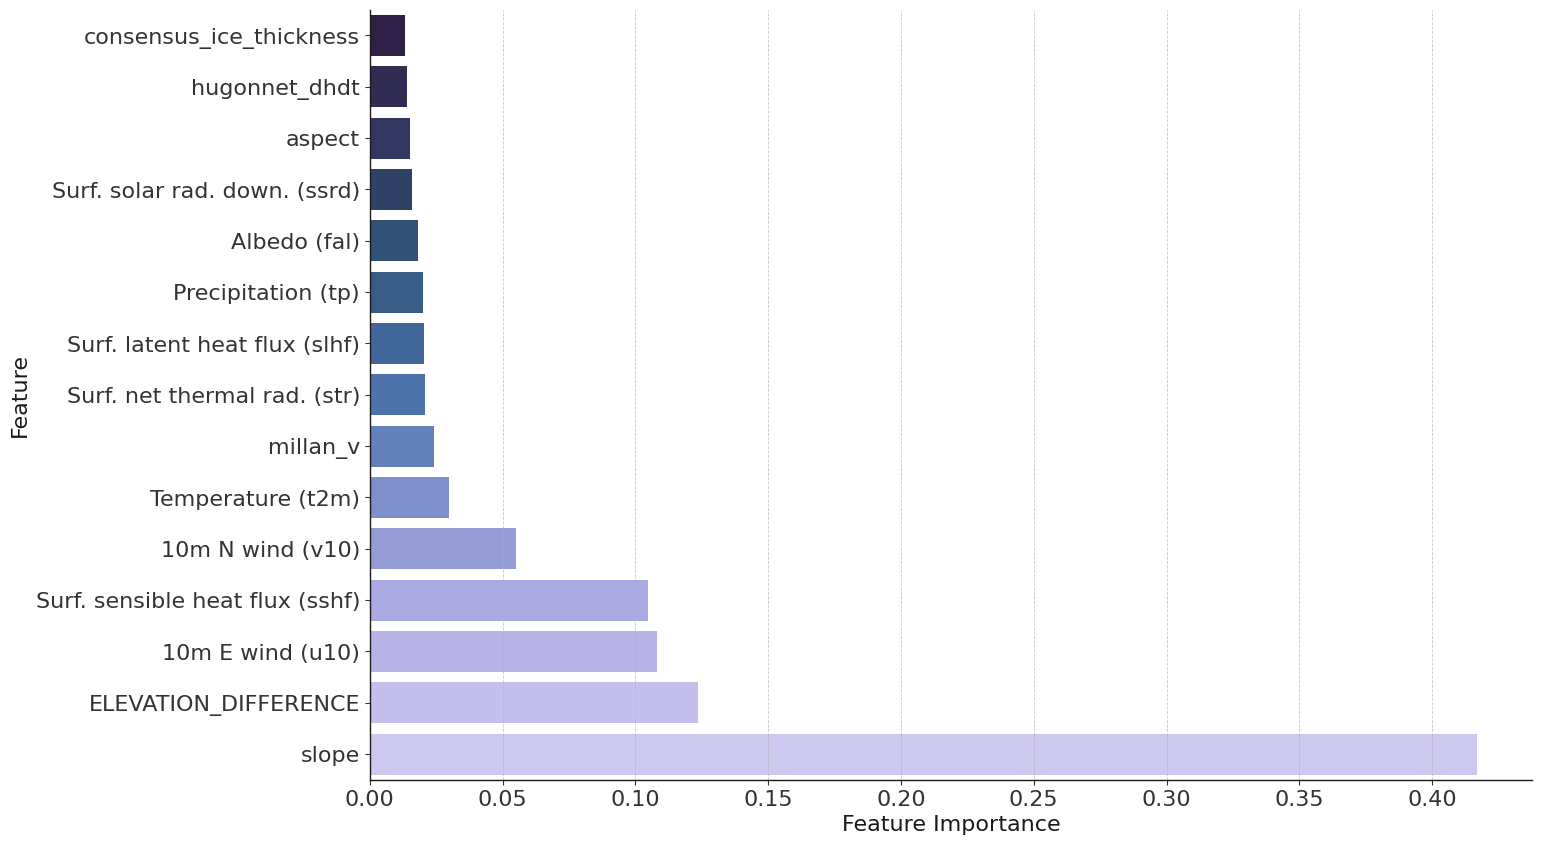

In [26]:
FIPlot(custom_model, feature_columns, vois_climate)

## Extrapolate in space


### Geodetic MB:

In [ ]:
# read geodetic MB:
geodeticMB = pd.read_csv(path_geodetic_MB_glamos + 'dV_DOI2024_allcomb.csv')

# filter to glaciers
all_gl = dataloader_gl.data.GLACIER.unique()

# get rgi of those glaciers:
rgi_gl = data_glamos[data_glamos.GLACIER.isin(all_gl)].RGIId.unique()
sgi_gl = [
    rgi_df[rgi_df['rgi_id.v6'] == rgi]['sgi-id'].values[0] for rgi in rgi_gl
]
geodeticMB = geodeticMB[geodeticMB['SGI-ID'].isin(sgi_gl)]

# Add glacierName to geodeticMB
# based  on SGI-ID
glacierNames = [
    rgi_df[rgi_df['sgi-id'] == sgi_id].index[0]
    for sgi_id in geodeticMB['SGI-ID'].values
]
geodeticMB['glacierName'] = glacierNames

# replace claridenL by clariden
geodeticMB['glacierName'] = geodeticMB['glacierName'].apply(
    lambda x: 'clariden' if x == 'claridenL' else x)

# get years per glacier
years_start_per_gl = geodeticMB.groupby(
    'glacierName')['Astart'].unique().apply(list).to_dict()
years_end_per_gl = geodeticMB.groupby('glacierName')['A_end'].unique().apply(
    list).to_dict()

periods_per_glacier = defaultdict(list)
geoMB_per_glacier = defaultdict(list)
# Iterate through the DataFrame rows
for _, row in geodeticMB.iterrows():
    glacierName = row['glacierName']
    start_year = row['Astart']
    end_year = row['A_end']
    geoMB = row['Bgeod']

    # Append the (start, end) tuple to the glacier's list
    periods_per_glacier[glacierName].append((start_year, end_year))
    geoMB_per_glacier[glacierName].append(geoMB)

### Glacier wide MB: 
Compute 2D fields.

#### List of glaciers to compute:

In [ ]:
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_pcsr + 'csv/')
]
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]
glacier_list = list(data_glamos.GLACIER.unique())
print('Number of glaciers with pcsr:', len(glacier_list))

satellite_glaciers = [
    'adler', 'aletsch', 'allalin', 'basodino', 'clariden', 'findelen', 'gries',
    'hohlaub', 'limmern', 'oberaar', 'plattalva', 'rhone', 'sanktanna',
    'schwarzbach', 'schwarzberg'
]
geodetic_glaciers = geodeticMB.glacierName.unique()
print('Number of glaciers with geodetic MB:', len(geodetic_glaciers))

# Intersection of both
common_glaciers = list(set(geodetic_glaciers) & set(glacier_list))
print('Number of common glaciers:', len(common_glaciers))

# Sort glaciers by area
gl_area = get_gl_area()
gl_area['clariden'] = gl_area['claridenL']


# Sort the lists by area if available in gl_area
def sort_by_area(glacier_list, gl_area):
    return sorted(glacier_list, key=lambda g: gl_area.get(g, 0), reverse=False)


glacier_list = sort_by_area(common_glaciers, gl_area)
glacier_list

### GLAMOS grids:

### Normal T & P:

In [ ]:
RUN = True
if RUN:
    # Define paths
    path_save_glw = 'results/nc/glamos/OGGM_vars/TP_T2m/'
    path_xr_grids = '/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/topo/GLAMOS_DEM/xr_masked_grids/'  # GLAMOS DEMs

    emptyfolder(path_save_glw)

    # Feature columns
    vois_climate = [
        't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
    ]
    feature_columns = [
        'ELEVATION_DIFFERENCE'
    ] + list(vois_climate) + list(vois_topographical)
    all_columns = feature_columns + cfg.fieldsNotFeatures
    print('Running for feature columns:', all_columns)

    for glacier_name in glacier_list:
        glacier_path = os.path.join(path_glacier_grid_glamos, glacier_name)

        if not os.path.exists(glacier_path):
            print(f"Folder not found for {glacier_name}, skipping...")
            continue

        glacier_files = sorted(
            [f for f in os.listdir(glacier_path) if glacier_name in f])

        print(f"Processing {glacier_name} ({len(glacier_files)} files)")

        for file_name in tqdm(glacier_files,
                              desc=f"Processing {glacier_name}",
                              leave=False):
            year = int(file_name.split('_')[2].split('.')[0])
            # process_glacier_file(cfg, custom_model, glacier_name, file_name,
            #                      path_save_glw, path_xr_grids, all_columns)

            # Load parquet input glacier grid file in monthly format (pre-processed)
            df_grid_monthly = pd.read_parquet(
                os.path.join(path_glacier_grid_glamos, glacier_name,
                             file_name))
            df_grid_monthly.drop_duplicates(inplace=True)

            # Keep only necessary columns, avoiding missing columns issues
            df_grid_monthly = df_grid_monthly[[
                col for col in all_columns if col in df_grid_monthly.columns
            ]]

            # Create geodata object
            geoData = mbm.GeoData(df_grid_monthly)

            # Computes and saves gridded MB for a year and glacier
            geoData.gridded_MB_pred(custom_model,
                                    glacier_name,
                                    year,
                                    all_columns,
                                    path_xr_grids,
                                    path_save_glw,
                                    cfg,
                                    save_monthly_pred=True)


In [ ]:
glacier_name = 'clariden'
year = 1951
# open xarray
xr.open_dataset(
    path_save_glw +
    f'{glacier_name}/{glacier_name}_{year}_annual.zarr').pred_masked.plot()